# <center>CDS525 Group Project</center>

This project is to design deep learning models to recognize handwriting image dataset KMNIST and K49.

By students:
*   SHEN Kunqi
*   ZENG Lu



INTRODUCE

This project mainly studies how to implement deep learning-based handwriting recognition on the Kmnist and K49 datasets. Firstly, the datasets are loaded and preprocessed. Then, experiments are conducted on the KMNIST dataset using a Multi-Layer Perceptron (MLP) deep learning neural network with six different settings. For each setting, model training, evaluation, performance visualization, and comparisons of predicted labels vs. actual labels are analyzed.

Subsequently, similar experiments are conducted for the LeNet deep learning neural network. Six different parameter settings are attempted on the KMNIST dataset, recording the training accuracy, loss, and test accuracy for each epoch and visualizing the results. The LeNet model is then applied to the K49 dataset, and three different parameter settings are tested. Similarly, the training accuracy, loss, and test accuracy for each epoch are recorded and visualized.

Finally, the performance of all LeNet models on the KMNIST and K49 datasets is compared. Overall, this Notebook file demonstrates in detail how to perform deep learning experiments using MLP and LeNet models on two datasets, as well as how to evaluate and visualize the experimental results.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F
import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from google.colab import files

In [ ]:
# these line are used to load the Google drive into the notebook
from google.colab import drive
drive.mount('/content/drive/')
data_path = "/content/drive/MyDrive/ColabNotebooks/CDS525/GroupProject/"  # this is your drive

Mounted at /content/drive/


## 1 Load Dataset - KMINST & K49


In [ ]:
# Define data processing steps
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

KMNIST Dataset

In [ ]:
# Load KMNIST training set and test set
km_trainset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
km_testset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 18165135/18165135 [00:10<00:00, 1676602.56it/s]


Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 340061.25it/s]


Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:02<00:00, 1469023.85it/s]


Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 12257326.76it/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



K49 Dataset

In [ ]:
'''
This part of the code is used to load the K49 dataset from 
googledrive. Since the K49 data is too large to be uploaded to 
moodle, the method of cloning git is used.
'''
# import numpy as np

# from google.colab import drive
# drive.mount('/content/drive')

# train_images = np.load('/content/drive/MyDrive/gp_525/k49-train-imgs.npz')['arr_0']
# test_images = np.load('/content/drive/MyDrive/gp_525/k49-test-imgs.npz')['arr_0']

# train_labels = np.load('/content/drive/MyDrive/gp_525/k49-train-labels.npz')['arr_0']
# test_labels = np.load('/content/drive/MyDrive/gp_525/k49-test-labels.npz')['arr_0']


# transform2 = transforms.Compose([transforms.Normalize( (0.5,), (0.5,) )])

Mounted at /content/drive


In [ ]:
# Clone the repository for the KMNIST dataset
!git clone https://github.com/rois-codh/kmnist.git

In [2]:
# Download the K49 dataset
import requests

urls = {
    "k49-train-imgs": "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz",
    "k49-train-labels": "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz",
    "k49-test-imgs": "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz",
    "k49-test-labels": "http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz",
}

for name, url in urls.items():
    response = requests.get(url)
    with open(f"{name}.npz", "wb") as f:
        f.write(response.content)
    print(f"Downloaded {name}.npz")

Downloaded k49-train-imgs.npz
Downloaded k49-train-labels.npz
Downloaded k49-test-imgs.npz
Downloaded k49-test-labels.npz


In [3]:
# Load the K49 dataset
import numpy as np

train_images = np.load('k49-train-imgs.npz')['arr_0']
test_images = np.load('k49-test-imgs.npz')['arr_0']

train_labels = np.load('k49-train-labels.npz')['arr_0']
test_labels = np.load('k49-test-labels.npz')['arr_0']


transform2 = transforms.Compose([transforms.Normalize( (0.5,), (0.5,) )])

In [4]:

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.data = self.data.unsqueeze(1)
        self.target = torch.from_numpy(target).long()
        self.transform = transform2
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [5]:
#import MyDataset
from torchvision import transforms
import torch

k49_trainset = MyDataset(train_images, train_labels, transform2)

k49_testset = MyDataset(test_images, test_labels, transform2)

## 2 Multi-layer Perceptron (MLP) Deep Learning Neural Network

To explore the MLP model performance with different settings, we design the model with six settings. See below list for details.</br> 

Setting 1: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = CrossEntropyLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 100 </br>

Setting 2: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = NLLLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 100 </br>

Setting 3: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = CrossEntropyLoss </br>
  - Learing rate = 0.001 </br>
  - Train dataset batch size = 100 </br>

Setting 4: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = NLLLoss </br>
  - Learing rate = 0.001 </br>
  - Train dataset batch size = 100 </br>

Setting 5: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = CrossEntropyLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 32 </br>

Setting 6: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = NLLLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 32 </br>

### 2.1 MLP01 - Setting 1 for KMNIST Dataset

Setting 1: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = CrossEntropyLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 100 </br>

#### 2.1.1 MLP01 Modeling and Evaluation

In [ ]:
# Define data loader
train_loader = torch.utils.data.DataLoader(km_trainset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(km_testset, batch_size=500, shuffle=True)

# Create model class
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layer=[120,84]):
        super().__init__()
        self.d1 = nn.Linear(input_size, layer[0])  # hidden layer 1
        self.d2 = nn.Linear(layer[0], layer[1])   # hidden layer 2
        self.d3 = nn.Linear(layer[1], output_size)   # output layer

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        x = self.d3(x)
        return F.log_softmax(x, dim=1)

# Define model
model = MultilayerPerceptron()

# Define loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train, test and evaluate the model
km_train_losses_mlp01 = []
km_train_accuracies_mlp01 = []
km_test_accuracies_mlp01 = []

for epoch in range(30):
    km_train_loss_mlp01 = 0.0
    km_train_correct_mlp01 = 0

    # Run the training batches
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        km_train_loss_mlp01 += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        km_train_correct_mlp01 += (predicted == target).sum().item()
    km_train_loss_mlp01 /= len(train_loader.dataset)
    km_train_accuracy_mlp01 = 100. * km_train_correct_mlp01 / len(train_loader.dataset)
    
    km_train_losses_mlp01.append(km_train_loss_mlp01)
    km_train_accuracies_mlp01.append(km_train_accuracy_mlp01/100)
    
    # Run the testing batches
    km_test_correct_mlp01 = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            km_test_correct_mlp01 += (predicted == target).sum().item()
    km_test_accuracy_mlp01 = 100. * km_test_correct_mlp01 / len(test_loader.dataset)

    km_test_accuracies_mlp01.append(km_test_accuracy_mlp01/100)
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tTest Accuracy: {:.2f}%'
          .format(epoch+1, km_train_loss_mlp01, km_train_accuracy_mlp01, km_test_accuracy_mlp01))


Epoch: 1 	Training Loss: 0.677092 	Training Accuracy: 79.15% 	Test Accuracy: 77.22%
Epoch: 2 	Training Loss: 0.308007 	Training Accuracy: 90.52% 	Test Accuracy: 82.32%
Epoch: 3 	Training Loss: 0.226857 	Training Accuracy: 93.01% 	Test Accuracy: 84.24%
Epoch: 4 	Training Loss: 0.177896 	Training Accuracy: 94.67% 	Test Accuracy: 86.37%
Epoch: 5 	Training Loss: 0.149044 	Training Accuracy: 95.49% 	Test Accuracy: 87.39%
Epoch: 6 	Training Loss: 0.125588 	Training Accuracy: 96.17% 	Test Accuracy: 85.80%
Epoch: 7 	Training Loss: 0.106222 	Training Accuracy: 96.68% 	Test Accuracy: 88.06%
Epoch: 8 	Training Loss: 0.090434 	Training Accuracy: 97.24% 	Test Accuracy: 88.42%
Epoch: 9 	Training Loss: 0.076441 	Training Accuracy: 97.75% 	Test Accuracy: 88.83%
Epoch: 10 	Training Loss: 0.068481 	Training Accuracy: 97.89% 	Test Accuracy: 88.70%
Epoch: 11 	Training Loss: 0.061020 	Training Accuracy: 98.06% 	Test Accuracy: 88.92%
Epoch: 12 	Training Loss: 0.051105 	Training Accuracy: 98.46% 	Test Accura

Filter out the best test accuracy and corresponding no of epoch and other values.

In [ ]:
# Collect the test results
km_mlp01_data = {
    "Model": ['MLP01']*30,
    "Epoch": np.arange(1,31),
    "Train_Loss": ['%.4f' % elem for elem in km_train_losses_mlp01],
    "Train_Accuracy": ['%.4f' % elem for elem in km_train_accuracies_mlp01],
    "Test_Accuracy": ['%.4f' % elem for elem in km_test_accuracies_mlp01]
    }

# Turn them to a data frame
km_mlp01 = pd.DataFrame(data=km_mlp01_data)

# Sort out the best test accuracy
km_mlp01_max = km_mlp01[km_mlp01['Test_Accuracy'] == km_mlp01['Test_Accuracy'].max()]
km_mlp01_max

,Model,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
22,MLP01,23,0.0066,0.9989,0.8998


#### 2.1.2 MLP01 Performance Visualization

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

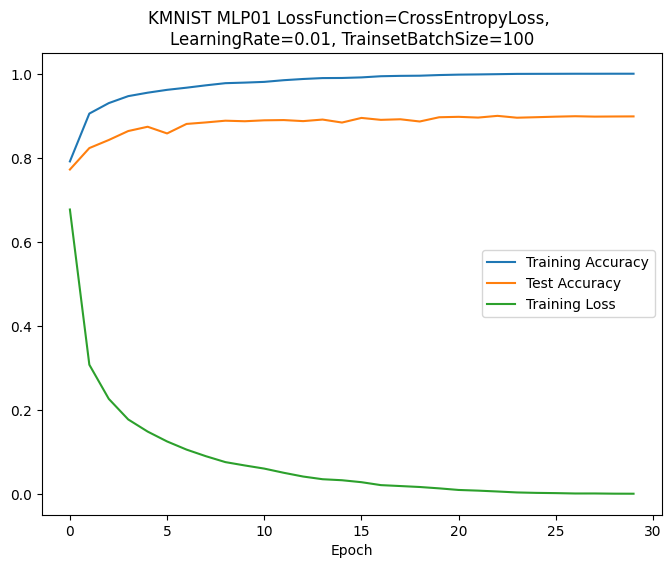

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

plt.figure(figsize=(8,6))
plt.title('KMNIST MLP01 LossFunction=CrossEntropyLoss, \nLearningRate=0.01, TrainsetBatchSize=100')
plt.plot(km_train_accuracies_mlp01, label='Training Accuracy')
plt.plot(km_test_accuracies_mlp01, label='Test Accuracy')
plt.plot(km_train_losses_mlp01, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.savefig('km_mlp01_modelPerf.png', dpi=300)
#files.download('km_mlp01_modelPerf.png')
plt.show()

#### 2.1.3 MLP01 Visualize Prediction Labels vs. Corresponding Actual labels

<font color=blue>
Visualize the predicted labels and the actual labels of the first 100 results in the test set.
</font>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

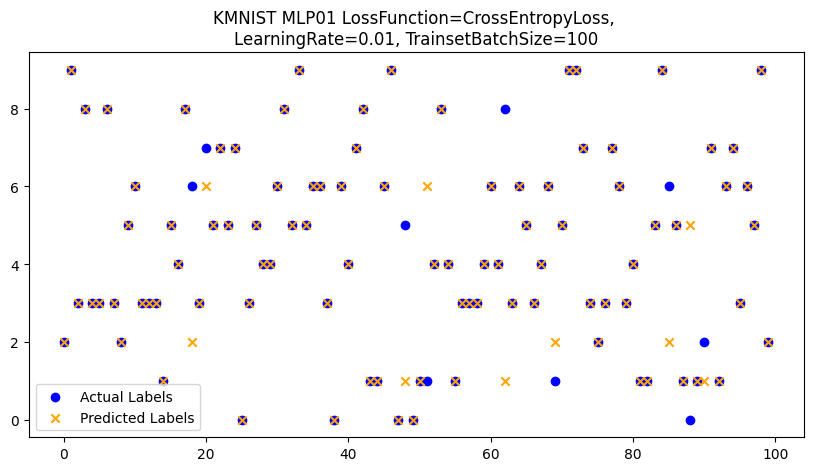

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
from torchvision import datasets, transforms

# Define data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loat test dataset
testset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Load model
# model = torch.load('model.pt')

# Predict test dataset label
model.eval()
test_predictions = []
test_inputs = []
for data, target in test_loader:
    output = model(data)
    predictions = torch.argmax(output, dim=1)
    test_predictions.extend(predictions.tolist())
    test_inputs.extend(data)

# Obtain the first 100 label data from test dataset and corresponding predicted label data
actual_labels = [testset.targets[i].item() for i in range(100)]
predicted_labels = test_predictions[:100]

# Create a data frame for storing the actual label data and the corresponding predicted label data
data = {'Actual Labels': actual_labels, 'Predicted Labels': predicted_labels}
km_df_mlp01= pd.DataFrame(data)
# df['Image'] = test_inputs[:100]
#print(km_df_mlp01)

# Plot the actual vs. the predicted label data
plt.figure(figsize=(10,5))
plt.title('KMNIST MLP01 LossFunction=CrossEntropyLoss, \nLearningRate=0.01, TrainsetBatchSize=100')
plt.scatter(list(km_df_mlp01.index), km_df_mlp01['Actual Labels'], color='blue', label='Actual Labels', marker='o')
plt.scatter(list(km_df_mlp01.index), km_df_mlp01['Predicted Labels'], color='orange', label='Predicted Labels', marker='x')
plt.legend()
#plt.savefig('km_mlp01_labelComp.png', dpi=300)
#files.download('km_mlp01_labelComp.png')
plt.show()

### 2.2 MLP02 - Setting 2 for KMNIST Dataset

Setting 2: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = NLLLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 100

#### 2.2.1 MLP02 Modeling and Evaluation

In [ ]:
# Define data loader
train_loader = torch.utils.data.DataLoader(km_trainset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(km_testset, batch_size=500, shuffle=True)

# Create model class
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layer=[120,84]):
        super().__init__()
        self.d1 = nn.Linear(input_size, layer[0])  # hidden layer 1
        self.d2 = nn.Linear(layer[0], layer[1])   # hidden layer 2
        self.d3 = nn.Linear(layer[1], output_size)   # output layer

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        x = self.d3(x)
        return F.log_softmax(x, dim=1)

# Define model
model = MultilayerPerceptron()

# Define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train, test and evaluate the model
km_train_losses_mlp02 = []
km_train_accuracies_mlp02 = []
km_test_accuracies_mlp02 = []

for epoch in range(30):
    km_train_loss_mlp02 = 0.0
    km_train_correct_mlp02 = 0

    # Run the training batches
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        km_train_loss_mlp02 += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        km_train_correct_mlp02 += (predicted == target).sum().item()
    km_train_loss_mlp02 /= len(train_loader.dataset)
    km_train_accuracy_mlp02 = 100. * km_train_correct_mlp02 / len(train_loader.dataset)
    
    km_train_losses_mlp02.append(km_train_loss_mlp02)
    km_train_accuracies_mlp02.append(km_train_accuracy_mlp02/100)
    
    # Run the testing batches
    km_test_correct_mlp02 = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            km_test_correct_mlp02 += (predicted == target).sum().item()
    km_test_accuracy_mlp02 = 100. * km_test_correct_mlp02 / len(test_loader.dataset)

    km_test_accuracies_mlp02.append(km_test_accuracy_mlp02/100)
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tTest Accuracy: {:.2f}%'
          .format(epoch+1, km_train_loss_mlp02, km_train_accuracy_mlp02, km_test_accuracy_mlp02))


Epoch: 1 	Training Loss: 0.683633 	Training Accuracy: 78.42% 	Test Accuracy: 75.95%
Epoch: 2 	Training Loss: 0.307093 	Training Accuracy: 90.58% 	Test Accuracy: 83.07%
Epoch: 3 	Training Loss: 0.226372 	Training Accuracy: 93.17% 	Test Accuracy: 83.72%
Epoch: 4 	Training Loss: 0.177307 	Training Accuracy: 94.52% 	Test Accuracy: 86.24%
Epoch: 5 	Training Loss: 0.146215 	Training Accuracy: 95.55% 	Test Accuracy: 86.42%
Epoch: 6 	Training Loss: 0.125053 	Training Accuracy: 96.18% 	Test Accuracy: 86.65%
Epoch: 7 	Training Loss: 0.106083 	Training Accuracy: 96.77% 	Test Accuracy: 88.14%
Epoch: 8 	Training Loss: 0.090013 	Training Accuracy: 97.22% 	Test Accuracy: 88.01%
Epoch: 9 	Training Loss: 0.079460 	Training Accuracy: 97.48% 	Test Accuracy: 87.50%
Epoch: 10 	Training Loss: 0.066830 	Training Accuracy: 97.90% 	Test Accuracy: 88.49%
Epoch: 11 	Training Loss: 0.061825 	Training Accuracy: 98.12% 	Test Accuracy: 87.17%
Epoch: 12 	Training Loss: 0.052797 	Training Accuracy: 98.39% 	Test Accura

Filter out the best test accuracy and corresponding no of epoch and other values.

In [ ]:
# Collect the test results
km_mlp02_data = {
    "Model": ['MLP02']*30,
    "Epoch": np.arange(1,31),
    "Train_Loss": ['%.4f' % elem for elem in km_train_losses_mlp02],
    "Train_Accuracy": ['%.4f' % elem for elem in km_train_accuracies_mlp02],
    "Test_Accuracy": ['%.4f' % elem for elem in km_test_accuracies_mlp02]
    }

# Turn them to a data frame
km_mlp02 = pd.DataFrame(data=km_mlp02_data)

# Sort out the best test accuracy
km_mlp02_max = km_mlp02[km_mlp02['Test_Accuracy'] == km_mlp02['Test_Accuracy'].max()]
km_mlp02_max

,Model,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
24,MLP02,25,0.0034,0.9996,0.8978


#### 2.2.2 MLP02 Performance Visualization

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

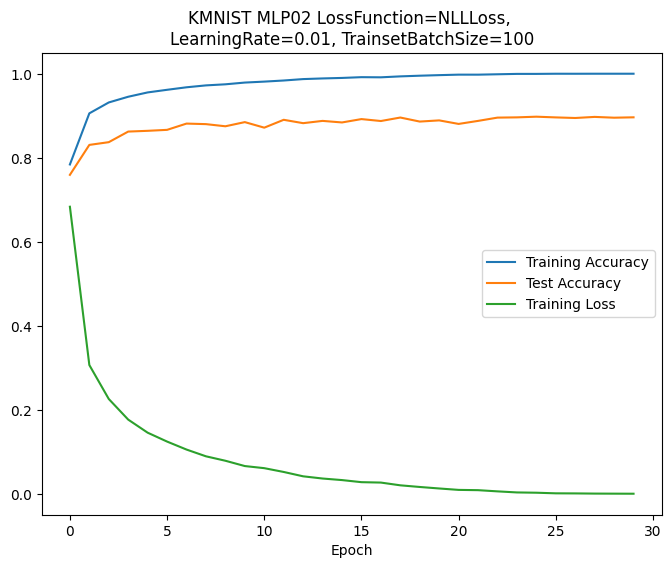

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

plt.figure(figsize=(8,6))
plt.title('KMNIST MLP02 LossFunction=NLLLoss, \nLearningRate=0.01, TrainsetBatchSize=100')
plt.plot(km_train_accuracies_mlp02, label='Training Accuracy')
plt.plot(km_test_accuracies_mlp02, label='Test Accuracy')
plt.plot(km_train_losses_mlp02, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.savefig('km_mlp02_modelPerf.png', dpi=300)
#files.download('km_mlp02_modelPerf.png')
plt.show()

#### 2.2.3 MLP02 Visualize Prediction Labels vs. Corresponding Actual labels

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

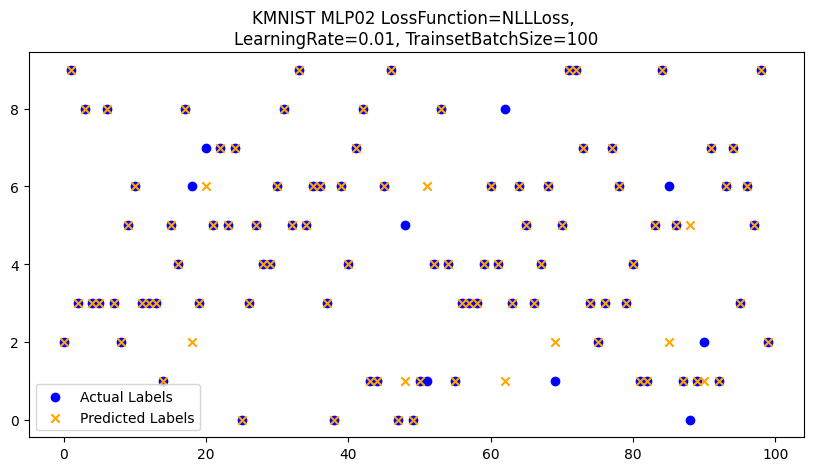

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
from torchvision import datasets, transforms

# Define data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loat test dataset
testset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Load model
# model = torch.load('model.pt')

# Predict test dataset label
model.eval()
test_predictions = []
test_inputs = []
for data, target in test_loader:
    output = model(data)
    predictions = torch.argmax(output, dim=1)
    test_predictions.extend(predictions.tolist())
    test_inputs.extend(data)

# Obtain the first 100 label data from test dataset and corresponding predicted label data
actual_labels = [testset.targets[i].item() for i in range(100)]
predicted_labels = test_predictions[:100]

# Create a data frame for storing the actual label data and the corresponding predicted label data
data = {'Actual Labels': actual_labels, 'Predicted Labels': predicted_labels}
km_df_mlp02 = pd.DataFrame(data)
# df['Image'] = test_inputs[:100]
#print(df_mlp02)

# Plot the actual vs. the predicted label data
plt.figure(figsize=(10,5))
plt.title('KMNIST MLP02 LossFunction=NLLLoss, \nLearningRate=0.01, TrainsetBatchSize=100')
plt.scatter(list(km_df_mlp02.index), km_df_mlp02['Actual Labels'], color='blue', label='Actual Labels', marker='o')
plt.scatter(list(km_df_mlp02.index), km_df_mlp02['Predicted Labels'], color='orange', label='Predicted Labels', marker='x')
plt.legend()
#plt.savefig('km_mlp02_labelComp.png', dpi=300)
#files.download('km_mlp02_labelComp.png')
plt.show()

### 2.3 MLP - Setting 3 for KMNIST Dataset

Setting 3: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = CrossEntropyLoss </br>
  - Learing rate = 0.001 </br>
  - Train dataset batch size = 100 </br>


#### 2.3.1 MLP03 Modeling and Evaluation

In [ ]:
# Define data loader
train_loader = torch.utils.data.DataLoader(km_trainset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(km_testset, batch_size=500, shuffle=True)

# Create model class
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layer=[120,84]):
        super().__init__()
        self.d1 = nn.Linear(input_size, layer[0])  # hidden layer 1
        self.d2 = nn.Linear(layer[0], layer[1])   # hidden layer 2
        self.d3 = nn.Linear(layer[1], output_size)   # output layer

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        x = self.d3(x)
        return F.log_softmax(x, dim=1)

# Define model
model = MultilayerPerceptron()

# Define loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train, test and evaluate the model
km_train_losses_mlp03 = []
km_train_accuracies_mlp03 = []
km_test_accuracies_mlp03 = []

for epoch in range(30):
    km_train_loss_mlp03 = 0.0
    km_train_correct_mlp03 = 0

    # Run the training batches
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        km_train_loss_mlp03 += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        km_train_correct_mlp03 += (predicted == target).sum().item()
    km_train_loss_mlp03 /= len(train_loader.dataset)
    km_train_accuracy_mlp03 = 100. * km_train_correct_mlp03 / len(train_loader.dataset)
    
    km_train_losses_mlp03.append(km_train_loss_mlp03)
    km_train_accuracies_mlp03.append(km_train_accuracy_mlp03/100)
    
    # Run the testing batches
    km_test_correct_mlp03 = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            km_test_correct_mlp03 += (predicted == target).sum().item()
    km_test_accuracy_mlp03 = 100. * km_test_correct_mlp03 / len(test_loader.dataset)

    km_test_accuracies_mlp03.append(km_test_accuracy_mlp03/100)
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tTest Accuracy: {:.2f}%'
          .format(epoch+1, km_train_loss_mlp03, km_train_accuracy_mlp03, km_test_accuracy_mlp03))


Epoch: 1 	Training Loss: 1.638702 	Training Accuracy: 52.50% 	Test Accuracy: 56.50%
Epoch: 2 	Training Loss: 0.796229 	Training Accuracy: 76.37% 	Test Accuracy: 65.41%
Epoch: 3 	Training Loss: 0.628850 	Training Accuracy: 81.00% 	Test Accuracy: 68.57%
Epoch: 4 	Training Loss: 0.551667 	Training Accuracy: 83.36% 	Test Accuracy: 70.93%
Epoch: 5 	Training Loss: 0.497553 	Training Accuracy: 85.00% 	Test Accuracy: 72.54%
Epoch: 6 	Training Loss: 0.455420 	Training Accuracy: 86.22% 	Test Accuracy: 74.57%
Epoch: 7 	Training Loss: 0.417803 	Training Accuracy: 87.47% 	Test Accuracy: 75.71%
Epoch: 8 	Training Loss: 0.385499 	Training Accuracy: 88.49% 	Test Accuracy: 76.74%
Epoch: 9 	Training Loss: 0.358258 	Training Accuracy: 89.27% 	Test Accuracy: 78.01%
Epoch: 10 	Training Loss: 0.334639 	Training Accuracy: 89.90% 	Test Accuracy: 78.80%
Epoch: 11 	Training Loss: 0.313255 	Training Accuracy: 90.68% 	Test Accuracy: 79.85%
Epoch: 12 	Training Loss: 0.295226 	Training Accuracy: 91.18% 	Test Accura

Filter out the best test accuracy and corresponding no of epoch and other values.

In [ ]:
# Collect the test results
km_mlp03_data = {
    "Model": ['MLP03']*30,
    "Epoch": np.arange(1,31),
    "Train_Loss": ['%.4f' % elem for elem in km_train_losses_mlp03],
    "Train_Accuracy": ['%.4f' % elem for elem in km_train_accuracies_mlp03],
    "Test_Accuracy": ['%.4f' % elem for elem in km_test_accuracies_mlp03]
    }

# Turn them to a data frame
km_mlp03 = pd.DataFrame(data=km_mlp03_data)

# Sort out the best test accuracy
km_mlp03_max = km_mlp03[km_mlp03['Test_Accuracy'] == km_mlp03['Test_Accuracy'].max()]
km_mlp03_max

,Model,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
29,MLP03,30,0.1356,0.9617,0.8677


#### 2.3.2 MLP03 Performance Visualization

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

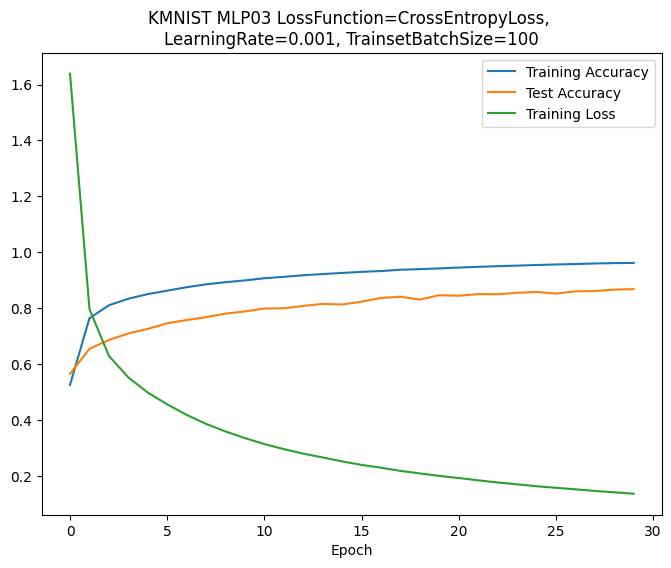

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

plt.figure(figsize=(8,6))
plt.title('KMNIST MLP03 LossFunction=CrossEntropyLoss, \nLearningRate=0.001, TrainsetBatchSize=100')
plt.plot(km_train_accuracies_mlp03, label='Training Accuracy')
plt.plot(km_test_accuracies_mlp03, label='Test Accuracy')
plt.plot(km_train_losses_mlp03, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.savefig('km_mlp03_modelPerf.png', dpi=300)
#files.download('km_mlp03_modelPerf.png')
plt.show()

#### 2.3.3 MLP03 Visualize Prediction Labels vs. Corresponding Actual labels

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

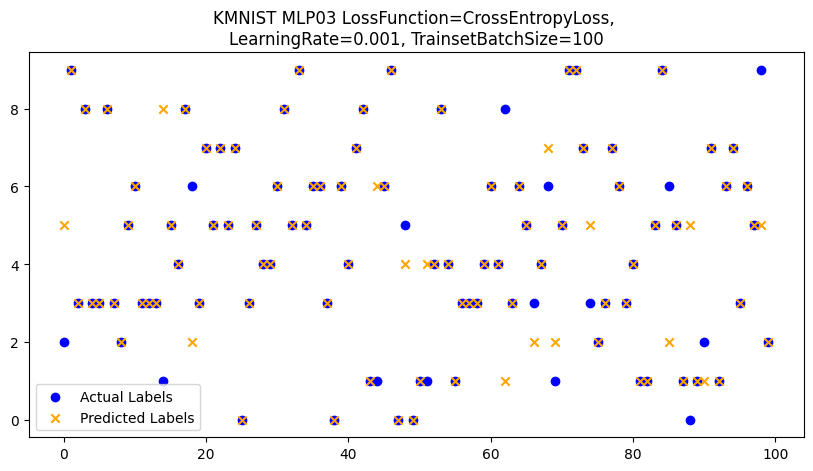

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
from torchvision import datasets, transforms

# Define data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loat test dataset
testset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Load model
# model = torch.load('model.pt')

# Predict test dataset label
model.eval()
test_predictions = []
test_inputs = []
for data, target in test_loader:
    output = model(data)
    predictions = torch.argmax(output, dim=1)
    test_predictions.extend(predictions.tolist())
    test_inputs.extend(data)

# Obtain the first 100 label data from test dataset and corresponding predicted label data
actual_labels = [testset.targets[i].item() for i in range(100)]
predicted_labels = test_predictions[:100]

# Create a data frame for storing the actual label data and the corresponding predicted label data
data = {'Actual Labels': actual_labels, 'Predicted Labels': predicted_labels}
km_df_mlp03 = pd.DataFrame(data)
# df['Image'] = test_inputs[:100]
#print(df_mlp03)

# Plot the actual vs. the predicted label data
plt.figure(figsize=(10,5))
plt.title('KMNIST MLP03 LossFunction=CrossEntropyLoss, \nLearningRate=0.001, TrainsetBatchSize=100')
plt.scatter(list(km_df_mlp03.index), km_df_mlp03['Actual Labels'], color='blue', label='Actual Labels', marker='o')
plt.scatter(list(km_df_mlp03.index), km_df_mlp03['Predicted Labels'], color='orange', label='Predicted Labels', marker='x')
plt.legend()
#plt.savefig('km_mlp03_labelComp.png', dpi=300)
#files.download('km_mlp03_labelComp.png')
plt.show()

### 2.4 MLP - Setting 4 for KMNIST Dataset

Setting 4: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = NLLLoss </br>
  - Learing rate = 0.001 </br>
  - Train dataset batch size = 100 </br>

#### 2.4.1 MLP04 Modeling and Evaluation

In [ ]:
# Define data loader
train_loader = torch.utils.data.DataLoader(km_trainset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(km_testset, batch_size=500, shuffle=True)

# Create model class
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layer=[120,84]):
        super().__init__()
        self.d1 = nn.Linear(input_size, layer[0])  # hidden layer 1
        self.d2 = nn.Linear(layer[0], layer[1])   # hidden layer 2
        self.d3 = nn.Linear(layer[1], output_size)   # output layer

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        x = self.d3(x)
        return F.log_softmax(x, dim=1)

# Define model
model = MultilayerPerceptron()

# Define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train, test and evaluate the model
km_train_losses_mlp04 = []
km_train_accuracies_mlp04 = []
km_test_accuracies_mlp04 = []

for epoch in range(30):
    km_train_loss_mlp04 = 0.0
    km_train_correct_mlp04 = 0

    # Run the training batches
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        km_train_loss_mlp04 += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        km_train_correct_mlp04 += (predicted == target).sum().item()
    km_train_loss_mlp04 /= len(train_loader.dataset)
    km_train_accuracy_mlp04 = 100. * km_train_correct_mlp04 / len(train_loader.dataset)
    
    km_train_losses_mlp04.append(km_train_loss_mlp04)
    km_train_accuracies_mlp04.append(km_train_accuracy_mlp04/100)
    
    # Run the testing batches
    km_test_correct_mlp04 = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            km_test_correct_mlp04 += (predicted == target).sum().item()
    km_test_accuracy_mlp04 = 100. * km_test_correct_mlp04 / len(test_loader.dataset)

    km_test_accuracies_mlp04.append(km_test_accuracy_mlp04/100)
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tTest Accuracy: {:.2f}%'
          .format(epoch+1, km_train_loss_mlp04, km_train_accuracy_mlp04, km_test_accuracy_mlp04))


Epoch: 1 	Training Loss: 1.570420 	Training Accuracy: 56.44% 	Test Accuracy: 59.57%
Epoch: 2 	Training Loss: 0.748153 	Training Accuracy: 77.63% 	Test Accuracy: 65.26%
Epoch: 3 	Training Loss: 0.607945 	Training Accuracy: 81.77% 	Test Accuracy: 69.34%
Epoch: 4 	Training Loss: 0.537193 	Training Accuracy: 83.82% 	Test Accuracy: 71.11%
Epoch: 5 	Training Loss: 0.485713 	Training Accuracy: 85.39% 	Test Accuracy: 73.19%
Epoch: 6 	Training Loss: 0.443318 	Training Accuracy: 86.66% 	Test Accuracy: 74.55%
Epoch: 7 	Training Loss: 0.407933 	Training Accuracy: 87.74% 	Test Accuracy: 76.59%
Epoch: 8 	Training Loss: 0.377820 	Training Accuracy: 88.70% 	Test Accuracy: 76.55%
Epoch: 9 	Training Loss: 0.351432 	Training Accuracy: 89.47% 	Test Accuracy: 78.00%
Epoch: 10 	Training Loss: 0.329600 	Training Accuracy: 90.10% 	Test Accuracy: 79.23%
Epoch: 11 	Training Loss: 0.310237 	Training Accuracy: 90.74% 	Test Accuracy: 79.51%
Epoch: 12 	Training Loss: 0.293727 	Training Accuracy: 91.25% 	Test Accura

Filter out the best test accuracy and corresponding no of epoch and other values.

In [ ]:
# Collect the test results
km_mlp04_data = {
    "Model": ['MLP04']*30,
    "Epoch": np.arange(1,31),
    "Train_Loss": ['%.4f' % elem for elem in km_train_losses_mlp04],
    "Train_Accuracy": ['%.4f' % elem for elem in km_train_accuracies_mlp04],
    "Test_Accuracy": ['%.4f' % elem for elem in km_test_accuracies_mlp04]
    }

# Turn them to a data frame
km_mlp04 = pd.DataFrame(data=km_mlp04_data)

# Sort out the best test accuracy
km_mlp04_max = km_mlp04[km_mlp04['Test_Accuracy'] == km_mlp04['Test_Accuracy'].max()]
km_mlp04_max

,Model,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
29,MLP04,30,0.1350,0.9629,0.8684


#### 2.4.2 MLP04 Performance Visualization

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

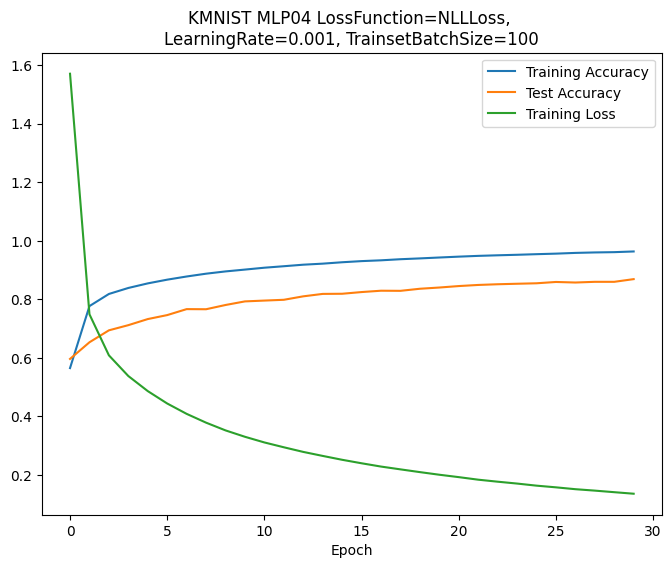

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

plt.figure(figsize=(8,6))
plt.title('KMNIST MLP04 LossFunction=NLLLoss, \nLearningRate=0.001, TrainsetBatchSize=100')
plt.plot(km_train_accuracies_mlp04, label='Training Accuracy')
plt.plot(km_test_accuracies_mlp04, label='Test Accuracy')
plt.plot(km_train_losses_mlp04, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.savefig('km_mlp04_modelPerf.png', dpi=300)
#files.download('km_mlp04_modelPerf.png')
plt.show()

#### 2.4.3 MLP04 Visualize Prediction Labels vs. Corresponding Actual labels

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

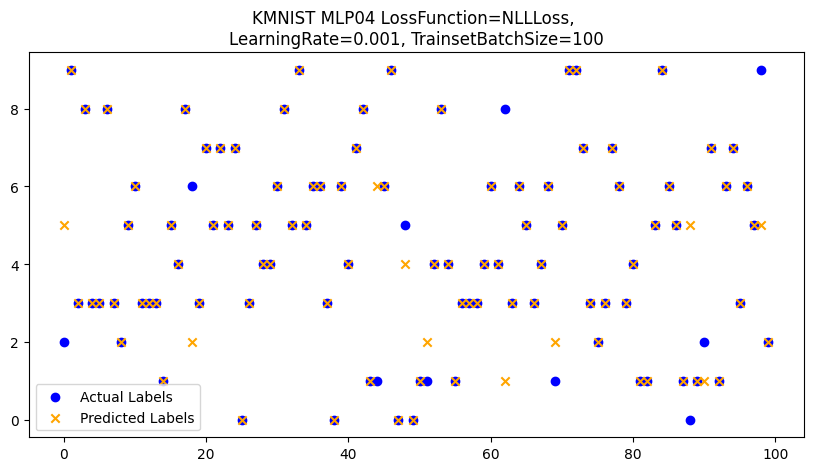

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
from torchvision import datasets, transforms

# Define data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loat test dataset
testset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Load model
# model = torch.load('model.pt')

# Predict test dataset label
model.eval()
test_predictions = []
test_inputs = []
for data, target in test_loader:
    output = model(data)
    predictions = torch.argmax(output, dim=1)
    test_predictions.extend(predictions.tolist())
    test_inputs.extend(data)

# Obtain the first 100 label data from test dataset and corresponding predicted label data
actual_labels = [testset.targets[i].item() for i in range(100)]
predicted_labels = test_predictions[:100]

# Create a data frame for storing the actual label data and the corresponding predicted label data
data = {'Actual Labels': actual_labels, 'Predicted Labels': predicted_labels}
km_df_mlp04 = pd.DataFrame(data)
# df_mlp04['Image'] = test_inputs[:100]
#print(df_mlp04)

# Plot the actual vs. the predicted label data
plt.figure(figsize=(10,5))
plt.title('KMNIST MLP04 LossFunction=NLLLoss, \nLearningRate=0.001, TrainsetBatchSize=100')
plt.scatter(list(km_df_mlp04.index), km_df_mlp04['Actual Labels'], color='blue', label='Actual Labels', marker='o')
plt.scatter(list(km_df_mlp04.index), km_df_mlp04['Predicted Labels'], color='orange', label='Predicted Labels', marker='x')
plt.legend()
#plt.savefig('km_mlp04_labelComp.png', dpi=300)
#files.download('km_mlp04_labelComp.png')
plt.show()

### 2.5 MLP05 - Setting 5 for KMNIST Dataset

Setting 5: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = CrossEntropyLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 32 </br>

#### 2.5.1 MLP05 Modeling and Evaluation

In [ ]:
# Define data loader
train_loader = torch.utils.data.DataLoader(km_trainset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(km_testset, batch_size=500, shuffle=True)

# Create model class
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layer=[120,84]):
        super().__init__()
        self.d1 = nn.Linear(input_size, layer[0])  # hidden layer 1
        self.d2 = nn.Linear(layer[0], layer[1])   # hidden layer 2
        self.d3 = nn.Linear(layer[1], output_size)   # output layer

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        x = self.d3(x)
        return F.log_softmax(x, dim=1)

# Define model
model = MultilayerPerceptron()

# Define loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train, test and evaluate the model
km_train_losses_mlp05 = []
km_train_accuracies_mlp05 = []
km_test_accuracies_mlp05 = []

for epoch in range(30):
    km_train_loss_mlp05 = 0.0
    km_train_correct_mlp05 = 0

    # Run the training batches
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        km_train_loss_mlp05 += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        km_train_correct_mlp05 += (predicted == target).sum().item()
    km_train_loss_mlp05 /= len(train_loader.dataset)
    km_train_accuracy_mlp05 = 100. * km_train_correct_mlp05 / len(train_loader.dataset)
    
    km_train_losses_mlp05.append(km_train_loss_mlp05)
    km_train_accuracies_mlp05.append(km_train_accuracy_mlp05/100)
    
    # Run the testing batches
    km_test_correct_mlp05 = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            km_test_correct_mlp05 += (predicted == target).sum().item()
    km_test_accuracy_mlp05 = 100. * km_test_correct_mlp05 / len(test_loader.dataset)

    km_test_accuracies_mlp05.append(km_test_accuracy_mlp05/100)
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tTest Accuracy: {:.2f}%'
          .format(epoch+1, km_train_loss_mlp05, km_train_accuracy_mlp05, km_test_accuracy_mlp05))


Epoch: 1 	Training Loss: 0.491071 	Training Accuracy: 84.52% 	Test Accuracy: 81.06%
Epoch: 2 	Training Loss: 0.236339 	Training Accuracy: 92.68% 	Test Accuracy: 86.21%
Epoch: 3 	Training Loss: 0.174458 	Training Accuracy: 94.66% 	Test Accuracy: 86.53%
Epoch: 4 	Training Loss: 0.139043 	Training Accuracy: 95.62% 	Test Accuracy: 86.66%
Epoch: 5 	Training Loss: 0.111130 	Training Accuracy: 96.51% 	Test Accuracy: 87.32%
Epoch: 6 	Training Loss: 0.095018 	Training Accuracy: 97.00% 	Test Accuracy: 88.66%
Epoch: 7 	Training Loss: 0.081746 	Training Accuracy: 97.43% 	Test Accuracy: 89.10%
Epoch: 8 	Training Loss: 0.070080 	Training Accuracy: 97.72% 	Test Accuracy: 89.59%
Epoch: 9 	Training Loss: 0.065105 	Training Accuracy: 97.84% 	Test Accuracy: 89.59%
Epoch: 10 	Training Loss: 0.054910 	Training Accuracy: 98.17% 	Test Accuracy: 89.61%
Epoch: 11 	Training Loss: 0.047441 	Training Accuracy: 98.42% 	Test Accuracy: 89.96%
Epoch: 12 	Training Loss: 0.045269 	Training Accuracy: 98.51% 	Test Accura

Filter out the best test accuracy and corresponding no of epoch and other values.

In [ ]:
# Collect the test results
km_mlp05_data = {
    "Model": ['MLP05']*30,
    "Epoch": np.arange(1,31),
    "Train_Loss": ['%.4f' % elem for elem in km_train_losses_mlp05],
    "Train_Accuracy": ['%.4f' % elem for elem in km_train_accuracies_mlp05],
    "Test_Accuracy": ['%.4f' % elem for elem in km_test_accuracies_mlp05]
    }

# Turn them to a data frame
km_mlp05 = pd.DataFrame(data=km_mlp05_data)

# Sort out the best test accuracy
km_mlp05_max = km_mlp05[km_mlp05['Test_Accuracy'] == km_mlp05['Test_Accuracy'].max()]
km_mlp05_max

,Model,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
21,MLP05,22,0.0197,0.9936,0.9028


#### 2.5.2 MLP05 Performance Visualization

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

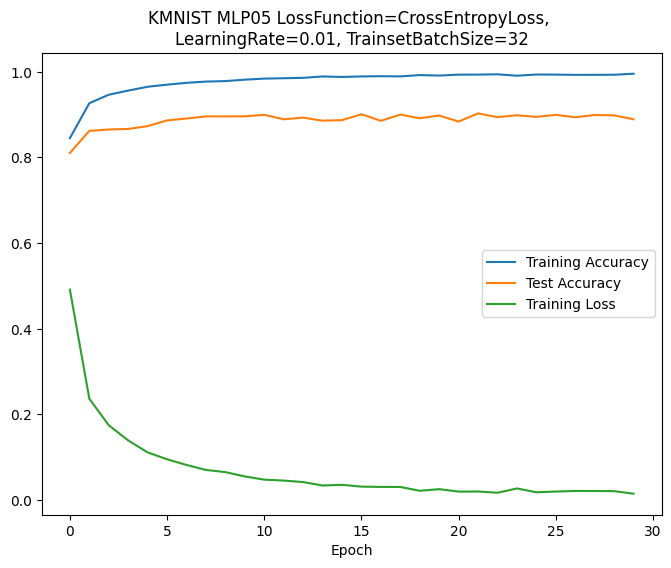

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

plt.figure(figsize=(8,6))
plt.title('KMNIST MLP05 LossFunction=CrossEntropyLoss, \nLearningRate=0.01, TrainsetBatchSize=32')
plt.plot(km_train_accuracies_mlp05, label='Training Accuracy')
plt.plot(km_test_accuracies_mlp05, label='Test Accuracy')
plt.plot(km_train_losses_mlp05, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.savefig('km_mlp05_modelPerf.png', dpi=300)
#files.download('km_mlp05_modelPerf.png')
plt.show()

#### 2.5.3 MLP05 Visualize Prediction Labels vs. Corresponding Actual labels

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

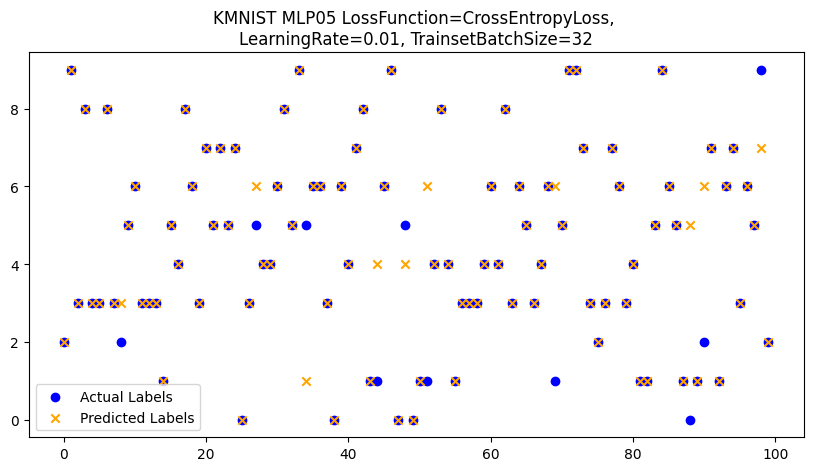

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
from torchvision import datasets, transforms

# Define data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loat test dataset
testset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Load model
# model = torch.load('model.pt')

# Predict test dataset label
model.eval()
test_predictions = []
test_inputs = []
for data, target in test_loader:
    output = model(data)
    predictions = torch.argmax(output, dim=1)
    test_predictions.extend(predictions.tolist())
    test_inputs.extend(data)

# Obtain the first 100 label data from test dataset and corresponding predicted label data
actual_labels = [testset.targets[i].item() for i in range(100)]
predicted_labels = test_predictions[:100]

# Create a data frame for storing the actual label data and the corresponding predicted label data
data = {'Actual Labels': actual_labels, 'Predicted Labels': predicted_labels}
km_df_mlp05 = pd.DataFrame(data)
# df['Image'] = test_inputs[:100]
#print(df_mlp05)

# Plot the actual vs. the predicted label data
plt.figure(figsize=(10,5))
plt.title('KMNIST MLP05 LossFunction=CrossEntropyLoss, \nLearningRate=0.01, TrainsetBatchSize=32')
plt.scatter(list(km_df_mlp05.index), km_df_mlp05['Actual Labels'], color='blue', label='Actual Labels', marker='o')
plt.scatter(list(km_df_mlp05.index), km_df_mlp05['Predicted Labels'], color='orange', label='Predicted Labels', marker='x')
plt.legend()
#plt.savefig('km_mlp05_labelComp.png', dpi=300)
#files.download('km_mlp05_labelComp.png')
plt.show()

### 2.6 MLP - Setting 6 for KMNIST Dataset

Setting 6: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = NLLLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 32 </br>

#### 2.6.1 MLP06 Modeling and Evaluation

In [ ]:
# Define data loader
train_loader = torch.utils.data.DataLoader(km_trainset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(km_testset, batch_size=500, shuffle=True)

# Create model class
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layer=[120,84]):
        super().__init__()
        self.d1 = nn.Linear(input_size, layer[0])  # hidden layer 1
        self.d2 = nn.Linear(layer[0], layer[1])   # hidden layer 2
        self.d3 = nn.Linear(layer[1], output_size)   # output layer

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        x = self.d3(x)
        return F.log_softmax(x, dim=1)

# Define model
model = MultilayerPerceptron()

# Define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train, test and evaluate the model
km_train_losses_mlp06 = []
km_train_accuracies_mlp06 = []
km_test_accuracies_mlp06 = []

for epoch in range(30):
    km_train_loss_mlp06 = 0.0
    km_train_correct_mlp06 = 0

    # Run the training batches
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        km_train_loss_mlp06 += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        km_train_correct_mlp06 += (predicted == target).sum().item()
    km_train_loss_mlp06 /= len(train_loader.dataset)
    km_train_accuracy_mlp06 = 100. * km_train_correct_mlp06 / len(train_loader.dataset)
    
    km_train_losses_mlp06.append(km_train_loss_mlp06)
    km_train_accuracies_mlp06.append(km_train_accuracy_mlp06/100)
    
    # Run the testing batches
    km_test_correct_mlp06 = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            km_test_correct_mlp06 += (predicted == target).sum().item()
    km_test_accuracy_mlp06 = 100. * km_test_correct_mlp06 / len(test_loader.dataset)

    km_test_accuracies_mlp06.append(km_test_accuracy_mlp06/100)
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tTest Accuracy: {:.2f}%'
          .format(epoch+1, km_train_loss_mlp06, km_train_accuracy_mlp06, km_test_accuracy_mlp06))


Epoch: 1 	Training Loss: 0.493451 	Training Accuracy: 84.13% 	Test Accuracy: 80.75%
Epoch: 2 	Training Loss: 0.239704 	Training Accuracy: 92.57% 	Test Accuracy: 85.02%
Epoch: 3 	Training Loss: 0.174652 	Training Accuracy: 94.58% 	Test Accuracy: 87.38%
Epoch: 4 	Training Loss: 0.139153 	Training Accuracy: 95.62% 	Test Accuracy: 88.22%
Epoch: 5 	Training Loss: 0.117243 	Training Accuracy: 96.38% 	Test Accuracy: 86.90%
Epoch: 6 	Training Loss: 0.099587 	Training Accuracy: 96.82% 	Test Accuracy: 87.50%
Epoch: 7 	Training Loss: 0.083757 	Training Accuracy: 97.33% 	Test Accuracy: 87.91%
Epoch: 8 	Training Loss: 0.070338 	Training Accuracy: 97.73% 	Test Accuracy: 88.08%
Epoch: 9 	Training Loss: 0.066122 	Training Accuracy: 97.86% 	Test Accuracy: 89.17%
Epoch: 10 	Training Loss: 0.056502 	Training Accuracy: 98.14% 	Test Accuracy: 89.68%
Epoch: 11 	Training Loss: 0.050700 	Training Accuracy: 98.35% 	Test Accuracy: 89.45%
Epoch: 12 	Training Loss: 0.041094 	Training Accuracy: 98.62% 	Test Accura

Filter out the best test accuracy and corresponding no of epoch and other values.

In [ ]:
# Collect the test results
km_mlp06_data = {
    "Model": ['MLP06']*30,
    "Epoch": np.arange(1,31),
    "Train_Loss": ['%.4f' % elem for elem in km_train_losses_mlp06],
    "Train_Accuracy": ['%.4f' % elem for elem in km_train_accuracies_mlp06],
    "Test_Accuracy": ['%.4f' % elem for elem in km_test_accuracies_mlp06]
    }

# Turn them to a data frame
km_mlp06 = pd.DataFrame(data=km_mlp06_data)

# Sort out the best test accuracy
km_mlp06_max = km_mlp06[km_mlp06['Test_Accuracy'] == km_mlp06['Test_Accuracy'].max()]
km_mlp06_max

,Model,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
28,MLP06,29,0.0078,0.9973,0.9057


#### 2.6.2 MLP06 Performance Visualization

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

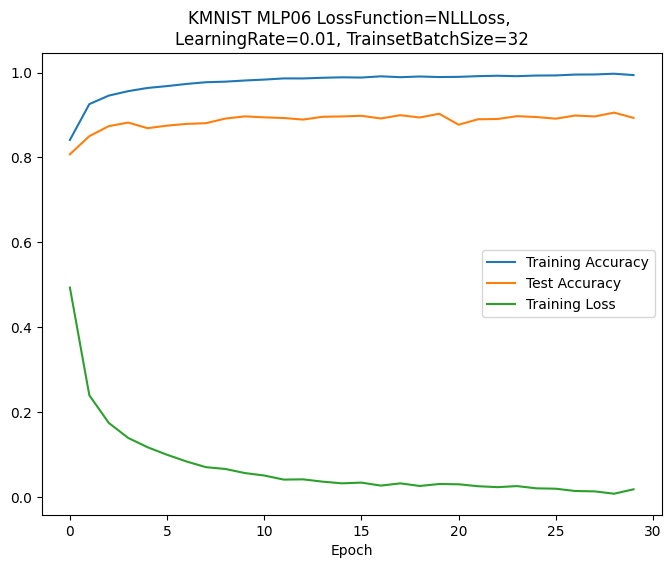

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

plt.figure(figsize=(8,6))
plt.title('KMNIST MLP06 LossFunction=NLLLoss, \nLearningRate=0.01, TrainsetBatchSize=32')
plt.plot(km_train_accuracies_mlp06, label='Training Accuracy')
plt.plot(km_test_accuracies_mlp06, label='Test Accuracy')
plt.plot(km_train_losses_mlp06, label='Training Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.savefig('km_mlp06_modelPerf.png', dpi=300)
#files.download('km_mlp06_modelPerf.png')
plt.show()

#### 2.6.3 MLP06 Visualize Prediction Labels vs. Corresponding Actual labels

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

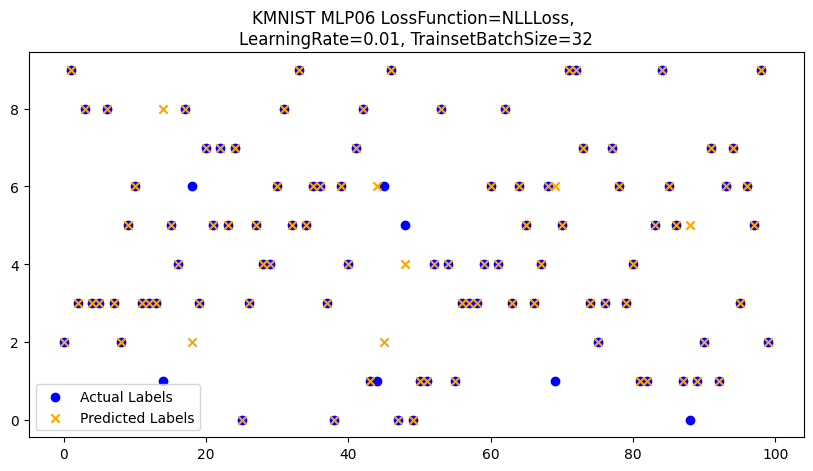

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
from torchvision import datasets, transforms

# Define data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loat test dataset
testset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Load model
# model = torch.load('model.pt')

# Predict test dataset label
model.eval()
test_predictions = []
test_inputs = []
for data, target in test_loader:
    output = model(data)
    predictions = torch.argmax(output, dim=1)
    test_predictions.extend(predictions.tolist())
    test_inputs.extend(data)

# Obtain the first 100 label data from test dataset and corresponding predicted label data
actual_labels = [testset.targets[i].item() for i in range(100)]
predicted_labels = test_predictions[:100]

# Create a data frame for storing the actual label data and the corresponding predicted label data
data = {'Actual Labels': actual_labels, 'Predicted Labels': predicted_labels}
km_df_mlp06 = pd.DataFrame(data)
# df_mlp06['Image'] = test_inputs[:100]
#print(df_mlp06)

# Plot the actual vs. the predicted label data
plt.figure(figsize=(10,5))
plt.title('KMNIST MLP06 LossFunction=NLLLoss, \nLearningRate=0.01, TrainsetBatchSize=32')
plt.scatter(list(km_df_mlp06.index), km_df_mlp06['Actual Labels'], color='blue', label='Actual Labels', marker='o')
plt.scatter(list(km_df_mlp06.index), km_df_mlp06['Predicted Labels'], color='orange', label='Predicted Labels', marker='x')
plt.legend()
#plt.savefig('km_mlp06_labelComp.png', dpi=300)
#files.download('km_mlp06_labelComp.png')
plt.show()

### 2.7 Performance Comparison Across All MLP Models for KMNIST Dataset

In [ ]:
# Collect the best test accuracy from all MLP models
frames = [km_mlp01_max, km_mlp02_max, km_mlp03_max, km_mlp04_max, km_mlp05_max, km_mlp06_max]

km_mlp_all = pd.concat(frames, ignore_index=True)
km_mlp_all

,Model,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
0,MLP01,23,0.0066,0.9989,0.8998
1,MLP02,25,0.0034,0.9996,0.8978
2,MLP03,30,0.1356,0.9617,0.8677
3,MLP04,30,0.1350,0.9629,0.8684
4,MLP05,22,0.0197,0.9936,0.9028
5,MLP06,29,0.0078,0.9973,0.9057


In [ ]:
km_mlp_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Model           6 non-null      object
 1   Epoch           6 non-null      int64 
 2   Train_Loss      6 non-null      object
 3   Train_Accuracy  6 non-null      object
 4   Test_Accuracy   6 non-null      object
dtypes: int64(1), object(4)
memory usage: 368.0+ bytes


In [ ]:
convert_dict = {'Train_Loss': float,
                'Train_Accuracy': float,
                'Test_Accuracy': float
                } 
  
km_mlp_all = km_mlp_all.astype(convert_dict)  
print(km_mlp_all.dtypes)

Model              object
Epoch               int64
Train_Loss        float64
Train_Accuracy    float64
Test_Accuracy     float64
dtype: object


In [ ]:
# Sort out the best test accuracy
km_mlp_all_max = km_mlp_all[km_mlp_all['Test_Accuracy'] == km_mlp_all['Test_Accuracy'].max()]
km_mlp_all_max

,Model,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
5,MLP06,29,0.0078,0.9973,0.9057


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

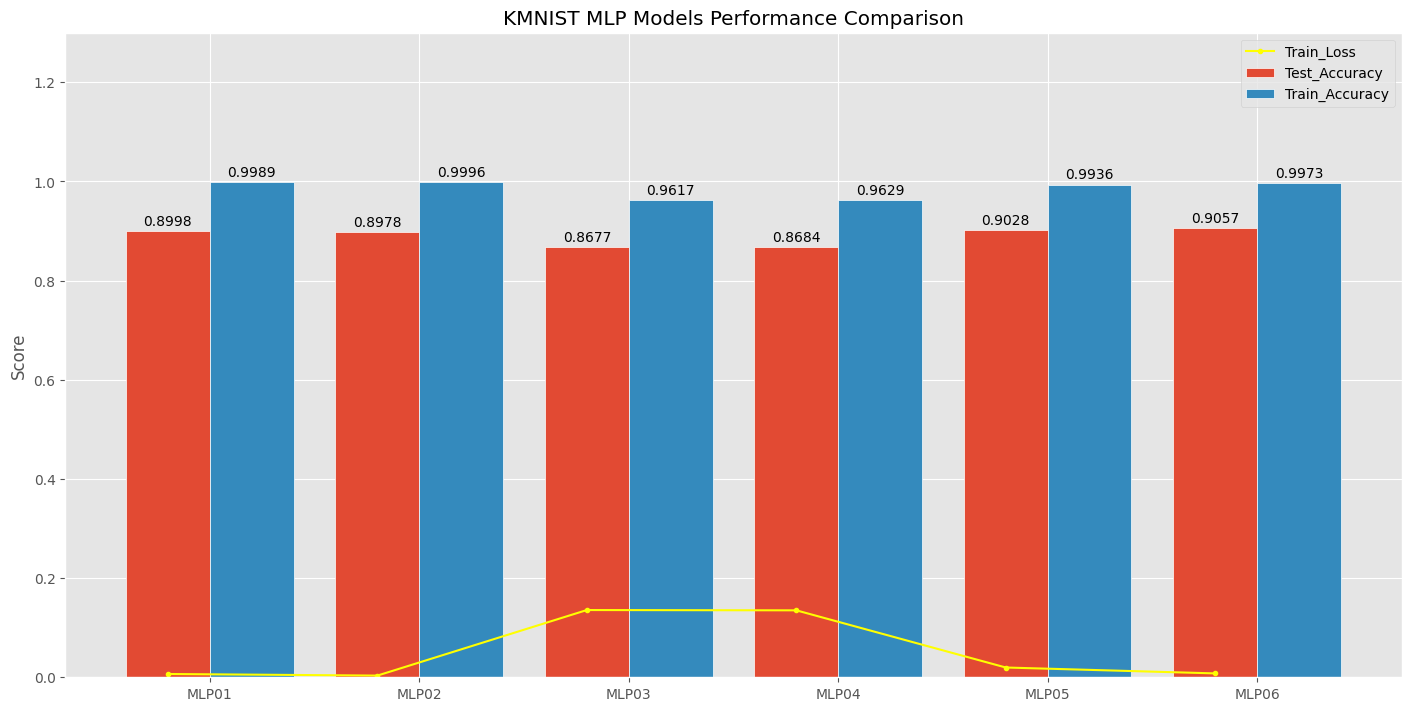

In [ ]:
#plot train accuracy and test accuracy as group bar chart
#plt.style.use('ggplot')
modelName = km_mlp_all.Model
metric_score = {
    'Test_Accuracy': km_mlp_all.Test_Accuracy,
    'Train_Accuracy': km_mlp_all.Train_Accuracy
    
}

x = np.arange(len(modelName))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(14,7), layout='constrained')

for attribute, measurement in metric_score.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, edgecolor='white')
    ax.bar_label(rects, padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('KMNIST MLP Models Performance Comparison')
ax.set_xticks(x + width/2, modelName)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0,1.3)

# plot train loss
plt.plot(km_mlp_all['Model'], km_mlp_all['Train_Loss'], color='yellow', marker='.', label='Train_Loss')
plt.legend()

#plt.savefig('km_mlp_all.png', dpi=300)
#files.download('km_mlp_all.png')
plt.show()


### 2.8 Extensive Experiments on Learning Rate

Based on the experiments above, try learning rate in a wider range by keeping the other settings unchanged to find out some rules.

- The options of learning rate: 0.1, 0.01, 0.001, 0.0001
- Other settings:
  - Epoch: 50
  - Two Loss functions: CrossEntropyLoss and NLLLosss
  - Batch size: 100


#### 2.8.1 CrossEntropyLoss

In [ ]:
lr = [0.1, 0.01, 0.001, 0.0001]
for lr in lr:

  # Define data loader
  train_loader = torch.utils.data.DataLoader(km_trainset, batch_size=100, shuffle=True)
  test_loader = torch.utils.data.DataLoader(km_testset, batch_size=500, shuffle=True)

  # Create model class
  class MultilayerPerceptron(nn.Module):
      def __init__(self, input_size=784, output_size=10, layer=[120,84]):
          super().__init__()
          self.d1 = nn.Linear(input_size, layer[0])  # hidden layer 1
          self.d2 = nn.Linear(layer[0], layer[1])   # hidden layer 2
          self.d3 = nn.Linear(layer[1], output_size)   # output layer

      def forward(self, x):
          x = x.view(-1, 28*28)
          x = F.relu(self.d1(x))
          x = F.relu(self.d2(x))
          x = self.d3(x)
          return F.log_softmax(x, dim=1)

  # Define model
  model = MultilayerPerceptron()


  # Define loss function and Optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  # Train, test and evaluate the model
  km_train_losses_mlp01 = []
  km_train_accuracies_mlp01 = []
  km_test_accuracies_mlp01 = []

  for epoch in range(50):
      km_train_loss_mlp01 = 0.0
      km_train_correct_mlp01 = 0

      # Run the training batches
      for data, target in train_loader:
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()
          km_train_loss_mlp01 += loss.item() * data.size(0)
          _, predicted = torch.max(output.data, 1)
          km_train_correct_mlp01 += (predicted == target).sum().item()
      km_train_loss_mlp01 /= len(train_loader.dataset)
      km_train_accuracy_mlp01 = 100. * km_train_correct_mlp01 / len(train_loader.dataset)
      
      km_train_losses_mlp01.append(km_train_loss_mlp01)
      km_train_accuracies_mlp01.append(km_train_accuracy_mlp01/100)
    
      # Run the testing batches
      km_test_correct_mlp01 = 0
      with torch.no_grad():
          for data, target in test_loader:
              output = model(data)
              _, predicted = torch.max(output.data, 1)
              km_test_correct_mlp01 += (predicted == target).sum().item()
      km_test_accuracy_mlp01 = 100. * km_test_correct_mlp01 / len(test_loader.dataset)

      km_test_accuracies_mlp01.append(km_test_accuracy_mlp01/100)
      print('lr: {} \tEpoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tTest Accuracy: {:.2f}%'
            .format(lr, epoch+1, km_train_loss_mlp01, km_train_accuracy_mlp01, km_test_accuracy_mlp01))

  # Collect the test results
  km_mlp01_data = {
            "Model_Setting": ['CELoss_BS100']*50,
            "Learning_Rate": [lr]*50,
            "Epoch": np.arange(1,51),
            "Train_Loss": ['%.4f' % elem for elem in km_train_losses_mlp01],
            "Train_Accuracy": ['%.4f' % elem for elem in km_train_accuracies_mlp01],
            "Test_Accuracy": ['%.4f' % elem for elem in km_test_accuracies_mlp01]
            }

  # Turn them to a data frame
  km_mlp01 = pd.DataFrame(data=km_mlp01_data)

  # Sort out the best test accuracy
  km_mlp01_max = km_mlp01[km_mlp01['Test_Accuracy'] == km_mlp01['Test_Accuracy'].max()]
  print("=" * 100)
  print(km_mlp01_max)
  print("=" * 100)
  

lr: 0.1 	Epoch: 1 	Training Loss: 0.579185 	Training Accuracy: 82.24% 	Test Accuracy: 76.27%
lr: 0.1 	Epoch: 2 	Training Loss: 0.355493 	Training Accuracy: 89.56% 	Test Accuracy: 79.96%
lr: 0.1 	Epoch: 3 	Training Loss: 0.310056 	Training Accuracy: 90.99% 	Test Accuracy: 80.78%
lr: 0.1 	Epoch: 4 	Training Loss: 0.280645 	Training Accuracy: 91.97% 	Test Accuracy: 82.06%
lr: 0.1 	Epoch: 5 	Training Loss: 0.240095 	Training Accuracy: 92.99% 	Test Accuracy: 82.07%
lr: 0.1 	Epoch: 6 	Training Loss: 0.227231 	Training Accuracy: 93.58% 	Test Accuracy: 83.18%
lr: 0.1 	Epoch: 7 	Training Loss: 0.212484 	Training Accuracy: 93.93% 	Test Accuracy: 85.53%
lr: 0.1 	Epoch: 8 	Training Loss: 0.197084 	Training Accuracy: 94.39% 	Test Accuracy: 85.18%
lr: 0.1 	Epoch: 9 	Training Loss: 0.196902 	Training Accuracy: 94.46% 	Test Accuracy: 82.56%
lr: 0.1 	Epoch: 10 	Training Loss: 0.198146 	Training Accuracy: 94.55% 	Test Accuracy: 83.75%
lr: 0.1 	Epoch: 11 	Training Loss: 0.181274 	Training Accuracy: 95.01

The results: </br>
Model_Setting  Learning_Rate  Epoch Train_Loss Train_Accuracy Test_Accuracy </br>
CELoss_BS100            0.1     21     0.1758         0.9558        0.8621 </br>
CELoss_BS100           0.01     29     0.0013         1.0000        0.9042 </br>
CELoss_BS100           0.01     31     0.0010         1.0000        0.9042 </br>
CELoss_BS100          0.001     50     0.0634         0.9850        0.8837 </br>
CELoss_BS100         0.0001     50     0.4522         0.8642        0.7401

#### 2.8.2 NLLLoss

In [ ]:
lr = [0.1, 0.01, 0.001, 0.0001]
for lr in lr:

  # Define data loader
  train_loader = torch.utils.data.DataLoader(km_trainset, batch_size=100, shuffle=True)
  test_loader = torch.utils.data.DataLoader(km_testset, batch_size=500, shuffle=True)

  # Create model class
  class MultilayerPerceptron(nn.Module):
      def __init__(self, input_size=784, output_size=10, layer=[120,84]):
          super().__init__()
          self.d1 = nn.Linear(input_size, layer[0])  # hidden layer 1
          self.d2 = nn.Linear(layer[0], layer[1])   # hidden layer 2
          self.d3 = nn.Linear(layer[1], output_size)   # output layer

      def forward(self, x):
          x = x.view(-1, 28*28)
          x = F.relu(self.d1(x))
          x = F.relu(self.d2(x))
          x = self.d3(x)
          return F.log_softmax(x, dim=1)

  # Define model
  model = MultilayerPerceptron()

  # Define loss function and optimizer
  criterion = nn.NLLLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  # Train, test and evaluate the model
  km_train_losses_mlp02 = []
  km_train_accuracies_mlp02 = []
  km_test_accuracies_mlp02 = []

  for epoch in range(50):
    km_train_loss_mlp02 = 0.0
    km_train_correct_mlp02 = 0

    # Run the training batches
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        km_train_loss_mlp02 += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        km_train_correct_mlp02 += (predicted == target).sum().item()
    km_train_loss_mlp02 /= len(train_loader.dataset)
    km_train_accuracy_mlp02 = 100. * km_train_correct_mlp02 / len(train_loader.dataset)    
    
    km_train_losses_mlp02.append(km_train_loss_mlp02)
    km_train_accuracies_mlp02.append(km_train_accuracy_mlp02/100)
    
    # Run the testing batches
    km_test_correct_mlp02 = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            km_test_correct_mlp02 += (predicted == target).sum().item()
    km_test_accuracy_mlp02 = 100. * km_test_correct_mlp02 / len(test_loader.dataset)

    km_test_accuracies_mlp02.append(km_test_accuracy_mlp02/100)
    print('lr: {} \tEpoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tTest Accuracy: {:.2f}%'
          .format(lr, epoch+1, km_train_loss_mlp02, km_train_accuracy_mlp02, km_test_accuracy_mlp02))


  # Collect the test results
  km_mlp02_data = {
              "Model_Setting": ['NLLLoss_BS100']*50,
              "Learning_Rate": [lr]*50,
              "Epoch": np.arange(1,51),
              "Train_Loss": ['%.4f' % elem for elem in km_train_losses_mlp02],
              "Train_Accuracy": ['%.4f' % elem for elem in km_train_accuracies_mlp02],
              "Test_Accuracy": ['%.4f' % elem for elem in km_test_accuracies_mlp02]
              }

  # Turn them to a data frame
  km_mlp02 = pd.DataFrame(data=km_mlp02_data)

  # Sort out the best test accuracy
  km_mlp02_max = km_mlp02[km_mlp02['Test_Accuracy'] == km_mlp02['Test_Accuracy'].max()]
  print("=" * 100)
  print(km_mlp02_max)
  print("=" * 100)


lr: 0.1 	Epoch: 1 	Training Loss: 0.685816 	Training Accuracy: 78.33% 	Test Accuracy: 77.16%
lr: 0.1 	Epoch: 2 	Training Loss: 0.308381 	Training Accuracy: 90.44% 	Test Accuracy: 81.37%
lr: 0.1 	Epoch: 3 	Training Loss: 0.226738 	Training Accuracy: 93.17% 	Test Accuracy: 83.94%
lr: 0.1 	Epoch: 4 	Training Loss: 0.176288 	Training Accuracy: 94.62% 	Test Accuracy: 86.29%
lr: 0.1 	Epoch: 5 	Training Loss: 0.146740 	Training Accuracy: 95.60% 	Test Accuracy: 87.04%
lr: 0.1 	Epoch: 6 	Training Loss: 0.121770 	Training Accuracy: 96.33% 	Test Accuracy: 87.10%
lr: 0.1 	Epoch: 7 	Training Loss: 0.105452 	Training Accuracy: 96.81% 	Test Accuracy: 87.73%
lr: 0.1 	Epoch: 8 	Training Loss: 0.089968 	Training Accuracy: 97.26% 	Test Accuracy: 88.47%
lr: 0.1 	Epoch: 9 	Training Loss: 0.076826 	Training Accuracy: 97.60% 	Test Accuracy: 88.69%
lr: 0.1 	Epoch: 10 	Training Loss: 0.067591 	Training Accuracy: 97.94% 	Test Accuracy: 88.52%
lr: 0.1 	Epoch: 11 	Training Loss: 0.056759 	Training Accuracy: 98.23

The results: </br>
Model_Setting  Learning_Rate  Epoch Train_Loss Train_Accuracy  Test_Accuracy  </br>
NLLLoss_BS100   0.1     29     0.0013         1.0000   0.9026 </br>
NLLLoss_BS100    0.01     24     0.0036         0.9996   0.9030 </br> 
NLLLoss_BS100   0.001     25     0.0033         0.9997   0.8985 </br>
NLLLoss_BS100  0.0001     48     0.0004         1.0000    0.9033  


#### 2.8.3 Experimental Results Visualization

In [ ]:
# Collect the test results
km_lr_data = {
    "Model_Setting": ['CrossEntropyLoss_BS100']*4 + ['NLLLoss_BS100']*4,
    "Learning_Rate": [0.1, 0.01, 0.001, 0.0001, 0.1, 0.01, 0.001, 0.0001],
    "Epoch": [21, 29, 50, 50, 29, 24, 25, 48],
    "Train_Loss": [0.1758, 0.0013, 0.0634, 0.4522, 0.0013, 0.0036, 0.0033, 0.0004],
    "Train_Accuracy": [0.9558, 1.0000, 0.9850, 0.8642, 1.0000, 0.9996, 0.9997, 1.0000],
    "Test_Accuracy": [0.8621, 0.9042, 0.8837, 0.7401, 0.9026, 0.9036, 0.8985, 0.9033]
    }

# Turn them to a data frame
km_lr = pd.DataFrame(data=km_lr_data)

km_lr.to_csv(data_path + 'km_lr.csv')


In [ ]:
km_lr

,Model_Setting,Learning_Rate,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
0,CrossEntropyLoss_BS100,0.1000,21,0.1758,0.9558,0.8621
1,CrossEntropyLoss_BS100,0.0100,29,0.0013,1.0000,0.9042
2,CrossEntropyLoss_BS100,0.0010,50,0.0634,0.9850,0.8837
3,CrossEntropyLoss_BS100,0.0001,50,0.4522,0.8642,0.7401
4,NLLLoss_BS100,0.1000,29,0.0013,1.0000,0.9026
5,NLLLoss_BS100,0.0100,24,0.0036,0.9996,0.9036
6,NLLLoss_BS100,0.0010,25,0.0033,0.9997,0.8985
7,NLLLoss_BS100,0.0001,48,0.0004,1.0000,0.9033


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

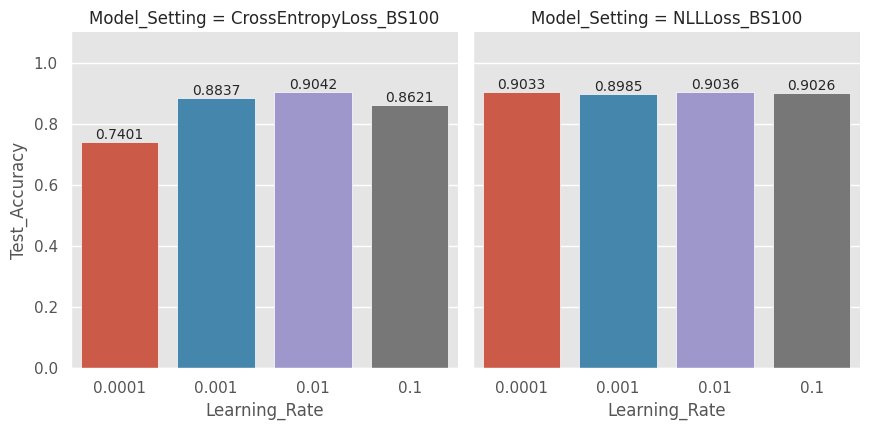

In [ ]:
plt.style.use('ggplot')

#sns.set_theme()
g = sns.catplot(
    data=km_lr, x='Learning_Rate', y='Test_Accuracy', col='Model_Setting',
    kind='bar', height=4.4, edgecolor='white'
)

for ax in g.axes.flat:
    for bars in ax.containers:
        ax.bar_label(bars)

g.set(ylim=(0,1.1))

#plt.savefig('km_mlp_lr.png', dpi=300)
#files.download('km_mlp_lr.png')

plt.show()

### 2.9 Extensive Experiments on Batch Size

Based on the basic experiments above, try batch size in a wider range by keeping the other settings unchanged to find out some rules.

- The options of batch size: 8, 32, 128, 512
- Other settings:
  - Epoch: 50
  - Two Loss functions: CrossEntropyLoss and NLLLosss
  - Learning rate: 0.01


#### 2.9.1 CrossEntropyLoss

In [ ]:
bs = [8, 32, 128, 512]
for bs in bs:
  
  # Define data loader
  train_loader = torch.utils.data.DataLoader(km_trainset, batch_size=bs, shuffle=True)
  test_loader = torch.utils.data.DataLoader(km_testset, batch_size=500, shuffle=True)

  # Create model class
  class MultilayerPerceptron(nn.Module):
      def __init__(self, input_size=784, output_size=10, layer=[120,84]):
          super().__init__()
          self.d1 = nn.Linear(input_size, layer[0])  # hidden layer 1
          self.d2 = nn.Linear(layer[0], layer[1])   # hidden layer 2
          self.d3 = nn.Linear(layer[1], output_size)   # output layer

      def forward(self, x):
          x = x.view(-1, 28*28)
          x = F.relu(self.d1(x))
          x = F.relu(self.d2(x))
          x = self.d3(x)
          return F.log_softmax(x, dim=1)

  # Define model
  model = MultilayerPerceptron()

  # Define loss function and Optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  # Train, test and evaluate the model
  km_train_losses_mlp05 = []
  km_train_accuracies_mlp05 = []
  km_test_accuracies_mlp05 = []

  for epoch in range(50):
    km_train_loss_mlp05 = 0.0
    km_train_correct_mlp05 = 0

    # Run the training batches
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        km_train_loss_mlp05 += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        km_train_correct_mlp05 += (predicted == target).sum().item()
    km_train_loss_mlp05 /= len(train_loader.dataset)
    km_train_accuracy_mlp05 = 100. * km_train_correct_mlp05 / len(train_loader.dataset)
    
    km_train_losses_mlp05.append(km_train_loss_mlp05)
    km_train_accuracies_mlp05.append(km_train_accuracy_mlp05/100)
    
    # Run the testing batches
    km_test_correct_mlp05 = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            km_test_correct_mlp05 += (predicted == target).sum().item()
    km_test_accuracy_mlp05 = 100. * km_test_correct_mlp05 / len(test_loader.dataset)

    km_test_accuracies_mlp05.append(km_test_accuracy_mlp05/100)
    print('bs: {} \tEpoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tTest Accuracy: {:.2f}%'
          .format(bs, epoch+1, km_train_loss_mlp05, km_train_accuracy_mlp05, km_test_accuracy_mlp05))

  # Collect the test results
  km_mlp05_data = {
            "Model_Setting": ['CELoss_lr0.01']*50,
            "Batch_Size": [bs]*50,
            "Epoch": np.arange(1,51),
            "Train_Loss": ['%.4f' % elem for elem in km_train_losses_mlp05],
            "Train_Accuracy": ['%.4f' % elem for elem in km_train_accuracies_mlp05],
            "Test_Accuracy": ['%.4f' % elem for elem in km_test_accuracies_mlp05]
            }

  # Turn them to a data frame
  km_mlp05 = pd.DataFrame(data=km_mlp05_data)

  # Sort out the best test accuracy
  km_mlp05_max = km_mlp05[km_mlp05['Test_Accuracy'] == km_mlp05['Test_Accuracy'].max()]
  print("=" * 100)
  print(km_mlp05_max)
  print("=" * 100)


The results: </br>
Model_Setting  Batch_Size  Epoch Train_Loss Train_Accuracy Test_Accuracy  </br>
CELoss_lr0.01           8     11     0.2670         0.9362        0.8481   </br>
CELoss_lr0.01          32     35     0.0054         0.9983        0.9085  </br>
CELoss_lr0.01         128     33     0.0015         1.0000        0.9001   </br>
CELoss_lr0.01         512     37     0.0357         0.9925        0.8890


#### 2.9.2 NLLLoss

In [ ]:
bs = [8, 32, 128, 512]
for bs in bs:

  # Define data loader
  train_loader = torch.utils.data.DataLoader(km_trainset, batch_size=bs, shuffle=True)
  test_loader = torch.utils.data.DataLoader(km_testset, batch_size=500, shuffle=True)

  # Create model class
  class MultilayerPerceptron(nn.Module):
      def __init__(self, input_size=784, output_size=10, layer=[120,84]):
          super().__init__()
          self.d1 = nn.Linear(input_size, layer[0])  # hidden layer 1
          self.d2 = nn.Linear(layer[0], layer[1])   # hidden layer 2
          self.d3 = nn.Linear(layer[1], output_size)   # output layer

      def forward(self, x):
          x = x.view(-1, 28*28)
          x = F.relu(self.d1(x))
          x = F.relu(self.d2(x))
          x = self.d3(x)
          return F.log_softmax(x, dim=1)

  # Define model
  model = MultilayerPerceptron()

  # Define loss function and optimizer
  criterion = nn.NLLLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  # Train, test and evaluate the model
  km_train_losses_mlp06 = []
  km_train_accuracies_mlp06 = []
  km_test_accuracies_mlp06 = []

  for epoch in range(50):
    km_train_loss_mlp06 = 0.0
    km_train_correct_mlp06 = 0

    # Run the training batches
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        km_train_loss_mlp06 += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        km_train_correct_mlp06 += (predicted == target).sum().item()
    km_train_loss_mlp06 /= len(train_loader.dataset)
    km_train_accuracy_mlp06 = 100. * km_train_correct_mlp06 / len(train_loader.dataset)
    
    km_train_losses_mlp06.append(km_train_loss_mlp06)
    km_train_accuracies_mlp06.append(km_train_accuracy_mlp06/100)
    
    # Run the testing batches
    km_test_correct_mlp06 = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            km_test_correct_mlp06 += (predicted == target).sum().item()
    km_test_accuracy_mlp06 = 100. * km_test_correct_mlp06 / len(test_loader.dataset)

    km_test_accuracies_mlp06.append(km_test_accuracy_mlp06/100)
    print('bs: {} \tEpoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tTest Accuracy: {:.2f}%'
          .format(bs, epoch+1, km_train_loss_mlp06, km_train_accuracy_mlp06, km_test_accuracy_mlp06))


  # Collect the test results
  km_mlp06_data = {
            "Model_Setting": ['NLLLoss_lr0.01']*50,
            "Batch_Size": [bs]*50,
            "Epoch": np.arange(1,51),
            "Train_Loss": ['%.4f' % elem for elem in km_train_losses_mlp06],
            "Train_Accuracy": ['%.4f' % elem for elem in km_train_accuracies_mlp06],
            "Test_Accuracy": ['%.4f' % elem for elem in km_test_accuracies_mlp06]
            }

  # Turn them to a data frame
  km_mlp06 = pd.DataFrame(data=km_mlp06_data)

  # Sort out the best test accuracy
  km_mlp06_max = km_mlp06[km_mlp06['Test_Accuracy'] == km_mlp06['Test_Accuracy'].max()]
  print("=" * 100)
  print(km_mlp06_max)
  print("=" * 100)


The results: </br>
Model_Setting  Batch_Size  Epoch Train_Loss Train_Accuracy Test_Accuracy  </br>
NLLLoss_lr0.01           8      8     0.2373         0.9390        0.8513   </br>
NLLLoss_lr0.01          32     47     0.0000         1.0000        0.9067  </br>
NLLLoss_lr0.01         128     37     0.0011         1.0000        0.8952  </br>
NLLLoss_lr0.01         128     41     0.0009         1.0000        0.8952  </br>
NLLLoss_lr0.01         512     48     0.0199         0.9971        0.8875





#### 2.9.3 Experimental Results Visualization

In [ ]:
# Collect the test results
km_bs_data = {
    "Model_Setting": ['CrossEntropyLoss_lr0.01']*4 + ['NLLLoss_lr0.01']*4,
    "Batch_Size": [8, 32, 128, 512, 8, 32, 128, 512],
    "Epoch": [11, 35, 33, 37, 8, 47, 41, 48],
    "Train_Loss": [0.2670, 0.0054, 0.0015, 0.0357, 0.2373, 0.0000, 0.0009, 0.0199],
    "Train_Accuracy": [0.9362, 0.9983, 1.0000, 0.9925, 0.9390, 1.0000, 1.0000, 0.9971],
    "Test_Accuracy": [0.8481, 0.9085, 0.9001, 0.8890, 0.8513, 0.9067, 0.8952, 0.8875]
    }

# Turn them to a data frame
km_bs = pd.DataFrame(data=km_bs_data)

km_bs.to_csv(data_path + 'km_bs.csv')


In [ ]:
km_bs

,Model_Setting,Batch_Size,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
0,CrossEntropyLoss_lr0.01,8,11,0.2670,0.9362,0.8481
1,CrossEntropyLoss_lr0.01,32,35,0.0054,0.9983,0.9085
2,CrossEntropyLoss_lr0.01,128,33,0.0015,1.0000,0.9001
3,CrossEntropyLoss_lr0.01,512,37,0.0357,0.9925,0.8890
4,NLLLoss_lr0.01,8,8,0.2373,0.9390,0.8513
5,NLLLoss_lr0.01,32,47,0.0000,1.0000,0.9067
6,NLLLoss_lr0.01,128,41,0.0009,1.0000,0.8952
7,NLLLoss_lr0.01,512,48,0.0199,0.9971,0.8875


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

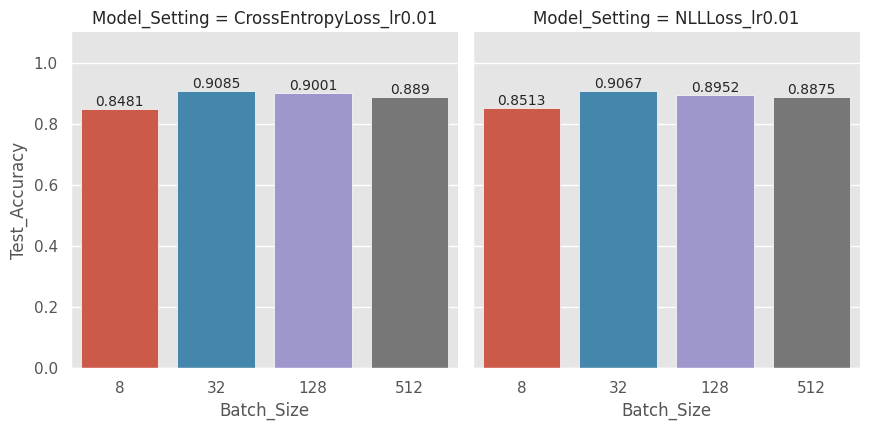

In [ ]:
plt.style.use('ggplot')
#sns.set_theme()
g = sns.catplot(
    data=km_bs, x='Batch_Size', y='Test_Accuracy', col='Model_Setting',
    kind='bar', height=4.4, edgecolor='white'
)

for ax in g.axes.flat:
    for bars in ax.containers:
        ax.bar_label(bars)

g.set(ylim=(0,1.1))

#plt.savefig('km_mlp_bs.png', dpi=300)
#files.download('km_mlp_bs.png')

plt.show()

## 3 LeNet Deep Learning Neural Network

### 3.1 Create LeNet & LeNet49 Class

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return nn.functional.log_softmax(x, dim=1)

In [ ]:
class LeNet49(nn.Module):
    def __init__(self):
        super(LeNet49, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 49)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return nn.functional.log_softmax(x, dim=1)

### 3.2 Define the Function to Run the Model

In [ ]:
def RunModel(modelname,dataset,learn_rate,batch_size,loss_fc,num_epoch):
  # Define data loader
  if dataset == 'kmnist':
    trainset = km_trainset
    testset = km_testset
    model = LeNet()
  elif dataset == 'k49':
    trainset = k49_trainset
    testset = k49_testset
    model = LeNet49()
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

  optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9)
  if loss_fc == 'nll':
    criterion = nn.NLLLoss()
    lossfunction = 'NLLLoss'
  elif loss_fc == 'ce':
    criterion = nn.CrossEntropyLoss()
    lossfunction = 'CrossEntropyLoss'
  
  # Training model
  train_losses = []
  train_accuracies = []
  test_accuracies = []

  for epoch in range(num_epoch):
      train_loss = 0.0
      train_correct = 0
      for data, target in train_loader:
          if dataset == 'k49':
            data, target = data.to(device), target.to(device)

          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * data.size(0)
          _, predicted = torch.max(output.data, 1)
          train_correct += (predicted == target).sum().item()
      train_loss /= len(train_loader.dataset)
      train_accuracy = 100. * train_correct / len(train_loader.dataset)
    
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy/100)
    
      # Test model
      test_correct = 0
      with torch.no_grad():
          for data, target in test_loader:
              output = model(data)
              _, predicted = torch.max(output.data, 1)
              test_correct += (predicted == target).sum().item()
      test_accuracy = 100. * test_correct / len(test_loader.dataset)

      test_accuracies.append(test_accuracy/100)
      print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tTest Accuracy: {:.2f}%'
            .format(epoch+1, train_loss, train_accuracy, test_accuracy))
      
  # Collect the test results
  modeldata = {
      "Model": [modelname]*num_epoch,
      "Epoch": np.arange(1,num_epoch+1),
      "Train_Loss": ['%.4f' % elem for elem in train_losses],
      "Train_Accuracy": ['%.4f' % elem for elem in train_accuracies],
      "Test_Accuracy": ['%.4f' % elem for elem in test_accuracies]
      }

  # Turn them to a data frame
  modeldata_pd = pd.DataFrame(data=modeldata)

  # Sort out the best test accuracy
  model_max = modeldata_pd[modeldata_pd['Test_Accuracy'] == modeldata_pd['Test_Accuracy'].max()]
      
    
  plt.plot(train_accuracies, label='Training Accuracy')
  plt.plot(test_accuracies, label='Test Accuracy')
  plt.plot(train_losses, label='Training Loss')
  plt.xlabel('Epoch')
  title=dataset+' '+modelname+' LossFunction='+lossfunction+ '\nLearningRate='+str(lr)+ ' TrainsetBatchSize='+str(batch_size)
  plt.title(title)
  plt.legend()
  pname = modelname+'_modelPerf.png'
  plt.savefig('/content/drive/MyDrive/gp_525/'+pname, dpi=300)
  plt.show()
  torch.save(model.state_dict(), 'model.pt')

  
  
  # Visualization
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))
  ])
  # Load model
  model.load_state_dict(torch.load('model.pt'))
  # Load dataset
  test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
  # Predict labels for the test set
  model.eval()
  test_predictions = []
  test_inputs = []
  for data, target in test_loader:
    output = model(data)
    predictions = torch.argmax(output, dim=1)
    test_predictions.extend(predictions.tolist())
    test_inputs.extend(data)

  # Get the labels and predicted labels for the first 100 data in the test set
  if dataset == 'kmnist':
    actual_labels = [testset.targets[i].item() for i in range(100)]
  elif dataset == 'k49':
    actual_labels = [testset.target[i].item() for i in range(100)]
  predicted_labels = test_predictions[:100]

  data = {'Actual Labels': actual_labels, 'Predicted Labels': predicted_labels}
  df = pd.DataFrame(data)
  # df['Image'] = test_inputs[:100]
  print(df)
  # Plot the actual vs. the predicted label data
  plt.figure()
  plt.scatter(list(df.index), df['Actual Labels'], color='blue', label='Actual Labels', marker='o')
  plt.scatter(list(df.index), df['Predicted Labels'], color='orange', label='Predicted Labels', marker='x')
  plt.title(title)
  plt.legend()
  pname = modelname+'_labelComp.png'
  plt.savefig('/content/drive/MyDrive/gp_525/'+pname, dpi=300)
  # files.download(data_path + 'mlp01_labelComp.png')
  plt.show()
  return model_max

### 3.3 LeNet Model Training on Kmnist Dataset

To explore the LeNet model performance with different settings, we design the model with six settings. See below list for details.</br> 

Setting 1: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = NLLLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 64 </br>

Setting 2: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = CrossEntropyLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 64 </br>

Setting 3: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = NLLLoss </br>
  - Learing rate = 0.001 </br>
  - Train dataset batch size = 64 </br>

Setting 4: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = CrossEntropyLoss </br>
  - Learing rate = 0.001 </br>
  - Train dataset batch size = 64 </br>

Setting 5: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = NLLLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 8 </br>

Setting 6: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = CrossEntropyLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 8 </br>

Each model parameter setting will be run in the function, and the following results will be obtained.
1. The training accuracy, loss, and test accuracy obtained by each epoch training.
2. Visualize the training accuracy, loss, and test accuracy changes with epochs.
3. The prediction of the model in the first 100 data of the test set and visualization.
4. The return from function is based on the best test accuracy.

Finally, 3.3.7 includes the summary and visualization of all 6 models.

#### 3.3.1 LeNet01 - Setting 1 for KMNIST Dataset

Epoch: 1 	Training Loss: 0.539736 	Training Accuracy: 82.50% 	Test Accuracy: 86.96%
Epoch: 2 	Training Loss: 0.123227 	Training Accuracy: 96.21% 	Test Accuracy: 91.35%
Epoch: 3 	Training Loss: 0.078463 	Training Accuracy: 97.60% 	Test Accuracy: 93.17%
Epoch: 4 	Training Loss: 0.055808 	Training Accuracy: 98.28% 	Test Accuracy: 93.18%
Epoch: 5 	Training Loss: 0.042188 	Training Accuracy: 98.64% 	Test Accuracy: 94.13%
Epoch: 6 	Training Loss: 0.031777 	Training Accuracy: 99.02% 	Test Accuracy: 93.54%
Epoch: 7 	Training Loss: 0.025773 	Training Accuracy: 99.14% 	Test Accuracy: 93.65%
Epoch: 8 	Training Loss: 0.020796 	Training Accuracy: 99.34% 	Test Accuracy: 94.55%
Epoch: 9 	Training Loss: 0.015629 	Training Accuracy: 99.49% 	Test Accuracy: 94.48%
Epoch: 10 	Training Loss: 0.014306 	Training Accuracy: 99.53% 	Test Accuracy: 94.32%
Epoch: 11 	Training Loss: 0.012277 	Training Accuracy: 99.64% 	Test Accuracy: 94.49%
Epoch: 12 	Training Loss: 0.008319 	Training Accuracy: 99.75% 	Test Accura

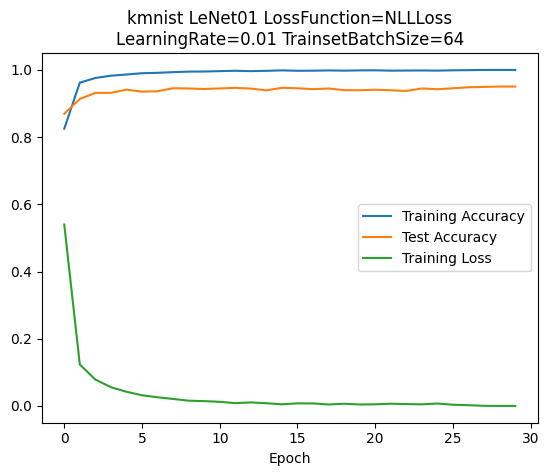

    Actual Labels  Predicted Labels
0               2                 2
1               9                 9
2               3                 3
3               8                 8
4               3                 3
..            ...               ...
95              3                 3
96              6                 6
97              5                 5
98              9                 0
99              2                 2

[100 rows x 2 columns]


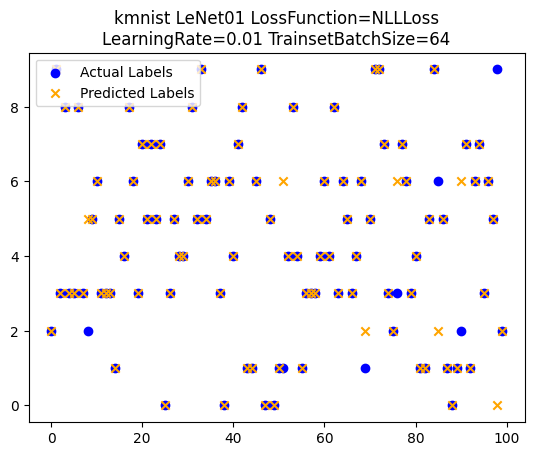

In [ ]:
name='LeNet01' # modelname
data = 'kmnist' # choose the dataset
lr = 0.01 # learning rate
batchsize = 64
loss='nll' # NLLLoss is used as the loss function
epochs = 30
km_lenet01_max=RunModel(name,data,lr,batchsize,loss,epochs) # The return is based on the best test accuracy

In [ ]:
# The best performance of this model
km_lenet01_max

,Model,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
29,LeNet01,30,0.0001,1.0000,0.9506


#### 3.3.2 LeNet02 - Setting 2 for KMNIST Dataset

Epoch: 1 	Training Loss: 0.591866 	Training Accuracy: 80.91% 	Test Accuracy: 87.58%
Epoch: 2 	Training Loss: 0.116226 	Training Accuracy: 96.44% 	Test Accuracy: 92.98%
Epoch: 3 	Training Loss: 0.072827 	Training Accuracy: 97.85% 	Test Accuracy: 93.46%
Epoch: 4 	Training Loss: 0.053618 	Training Accuracy: 98.35% 	Test Accuracy: 93.62%
Epoch: 5 	Training Loss: 0.038494 	Training Accuracy: 98.81% 	Test Accuracy: 94.42%
Epoch: 6 	Training Loss: 0.029066 	Training Accuracy: 99.07% 	Test Accuracy: 94.34%
Epoch: 7 	Training Loss: 0.022097 	Training Accuracy: 99.28% 	Test Accuracy: 93.98%
Epoch: 8 	Training Loss: 0.019237 	Training Accuracy: 99.36% 	Test Accuracy: 94.74%
Epoch: 9 	Training Loss: 0.013874 	Training Accuracy: 99.52% 	Test Accuracy: 94.55%
Epoch: 10 	Training Loss: 0.010081 	Training Accuracy: 99.66% 	Test Accuracy: 95.01%
Epoch: 11 	Training Loss: 0.008792 	Training Accuracy: 99.72% 	Test Accuracy: 94.53%
Epoch: 12 	Training Loss: 0.010348 	Training Accuracy: 99.66% 	Test Accura

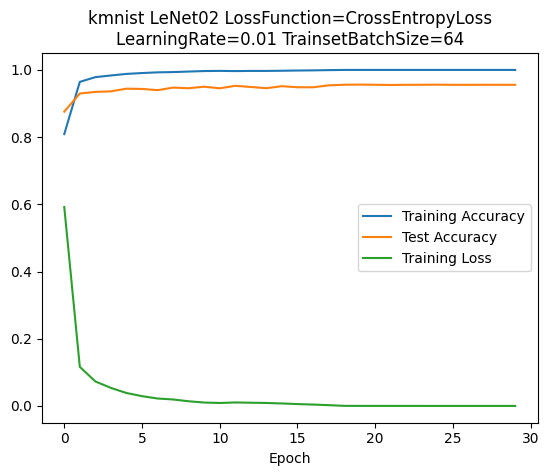

    Actual Labels  Predicted Labels
0               2                 2
1               9                 9
2               3                 3
3               8                 8
4               3                 3
..            ...               ...
95              3                 3
96              6                 6
97              5                 5
98              9                 0
99              2                 2

[100 rows x 2 columns]


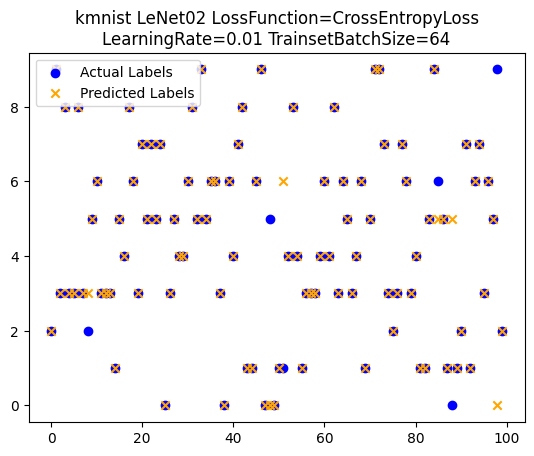

In [ ]:
name='LeNet02'
data = 'kmnist'
lr = 0.01
batchsize = 64
loss='ce' # CELoss is used as the loss function
epochs = 30
km_lenet02_max=RunModel(name,data,lr,batchsize,loss,epochs)

In [ ]:
# The best performance of this model
km_lenet02_max

,Model,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
19,LeNet02,20,0.0001,1.0000,0.9563


#### 3.3.3 LeNet03 - Setting 3 for KMNIST Dataset

Epoch: 1 	Training Loss: 2.037706 	Training Accuracy: 32.68% 	Test Accuracy: 48.79%
Epoch: 2 	Training Loss: 0.761007 	Training Accuracy: 76.58% 	Test Accuracy: 69.51%
Epoch: 3 	Training Loss: 0.430771 	Training Accuracy: 86.82% 	Test Accuracy: 77.21%
Epoch: 4 	Training Loss: 0.301431 	Training Accuracy: 90.83% 	Test Accuracy: 81.28%
Epoch: 5 	Training Loss: 0.236073 	Training Accuracy: 92.74% 	Test Accuracy: 83.90%
Epoch: 6 	Training Loss: 0.189398 	Training Accuracy: 94.29% 	Test Accuracy: 84.74%
Epoch: 7 	Training Loss: 0.158919 	Training Accuracy: 95.25% 	Test Accuracy: 87.20%
Epoch: 8 	Training Loss: 0.137103 	Training Accuracy: 95.90% 	Test Accuracy: 88.20%
Epoch: 9 	Training Loss: 0.119115 	Training Accuracy: 96.40% 	Test Accuracy: 89.68%
Epoch: 10 	Training Loss: 0.105303 	Training Accuracy: 96.81% 	Test Accuracy: 90.19%
Epoch: 11 	Training Loss: 0.094522 	Training Accuracy: 97.19% 	Test Accuracy: 91.15%
Epoch: 12 	Training Loss: 0.086064 	Training Accuracy: 97.49% 	Test Accura

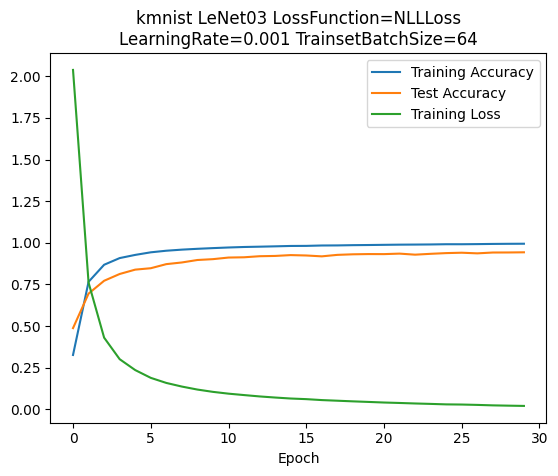

    Actual Labels  Predicted Labels
0               2                 2
1               9                 9
2               3                 3
3               8                 8
4               3                 3
..            ...               ...
95              3                 3
96              6                 6
97              5                 5
98              9                 7
99              2                 2

[100 rows x 2 columns]


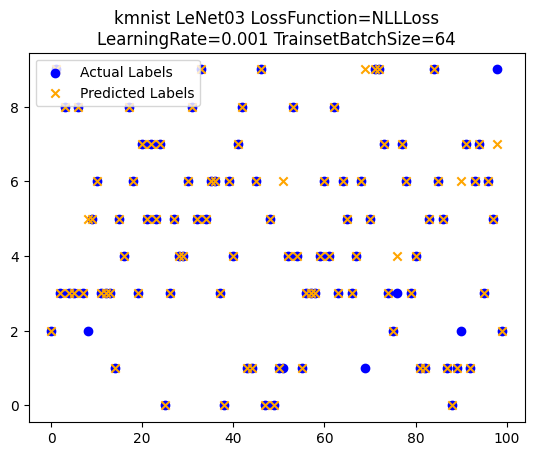

In [ ]:
name='LeNet03'
data = 'kmnist'
lr = 0.001
batchsize = 64
loss='nll'
epochs = 30
km_lenet03_max=RunModel(name,data,lr,batchsize,loss,epochs)

#### 3.3.4 LeNet04 - Setting 4 for KMNIST Dataset

Epoch: 1 	Training Loss: 1.970491 	Training Accuracy: 35.34% 	Test Accuracy: 53.99%
Epoch: 2 	Training Loss: 0.655452 	Training Accuracy: 79.88% 	Test Accuracy: 71.98%
Epoch: 3 	Training Loss: 0.378551 	Training Accuracy: 88.44% 	Test Accuracy: 79.78%
Epoch: 4 	Training Loss: 0.274790 	Training Accuracy: 91.55% 	Test Accuracy: 83.33%
Epoch: 5 	Training Loss: 0.220191 	Training Accuracy: 93.26% 	Test Accuracy: 85.97%
Epoch: 6 	Training Loss: 0.184527 	Training Accuracy: 94.32% 	Test Accuracy: 88.01%
Epoch: 7 	Training Loss: 0.159389 	Training Accuracy: 95.08% 	Test Accuracy: 88.89%
Epoch: 8 	Training Loss: 0.138299 	Training Accuracy: 95.74% 	Test Accuracy: 89.39%
Epoch: 9 	Training Loss: 0.123599 	Training Accuracy: 96.22% 	Test Accuracy: 89.64%
Epoch: 10 	Training Loss: 0.111692 	Training Accuracy: 96.54% 	Test Accuracy: 89.97%
Epoch: 11 	Training Loss: 0.102555 	Training Accuracy: 96.84% 	Test Accuracy: 91.42%
Epoch: 12 	Training Loss: 0.091706 	Training Accuracy: 97.20% 	Test Accura

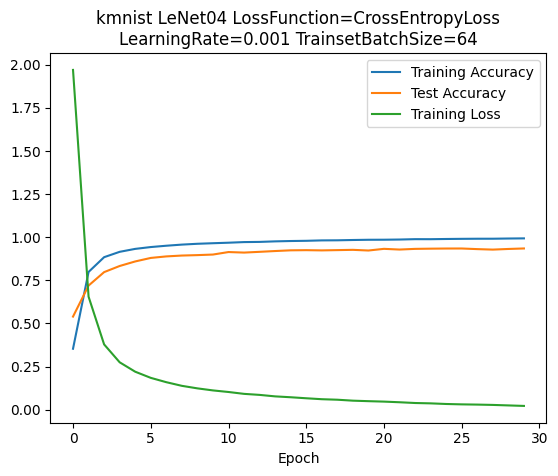

    Actual Labels  Predicted Labels
0               2                 2
1               9                 9
2               3                 3
3               8                 8
4               3                 3
..            ...               ...
95              3                 3
96              6                 6
97              5                 5
98              9                 0
99              2                 2

[100 rows x 2 columns]


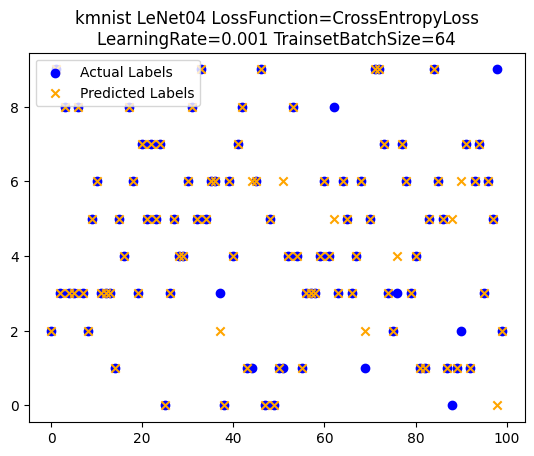

In [ ]:
name='LeNet04'
data = 'kmnist'
lr = 0.001
batchsize = 64
loss='ce'
epochs = 30
km_lenet04_max=RunModel(name,data,lr,batchsize,loss,epochs)

#### 3.3.5 LeNet05 - Setting 5 for KMNIST Dataset

Epoch: 1 	Training Loss: 0.362621 	Training Accuracy: 89.01% 	Test Accuracy: 86.58%
Epoch: 2 	Training Loss: 0.189352 	Training Accuracy: 95.00% 	Test Accuracy: 89.90%
Epoch: 3 	Training Loss: 0.164121 	Training Accuracy: 95.86% 	Test Accuracy: 90.27%
Epoch: 4 	Training Loss: 0.176559 	Training Accuracy: 95.72% 	Test Accuracy: 88.11%
Epoch: 5 	Training Loss: 0.237503 	Training Accuracy: 94.53% 	Test Accuracy: 87.55%
Epoch: 6 	Training Loss: 0.302519 	Training Accuracy: 93.40% 	Test Accuracy: 87.51%
Epoch: 7 	Training Loss: nan 	Training Accuracy: 36.16% 	Test Accuracy: 10.00%
Epoch: 8 	Training Loss: nan 	Training Accuracy: 10.00% 	Test Accuracy: 10.00%
Epoch: 9 	Training Loss: nan 	Training Accuracy: 10.00% 	Test Accuracy: 10.00%
Epoch: 10 	Training Loss: nan 	Training Accuracy: 10.00% 	Test Accuracy: 10.00%


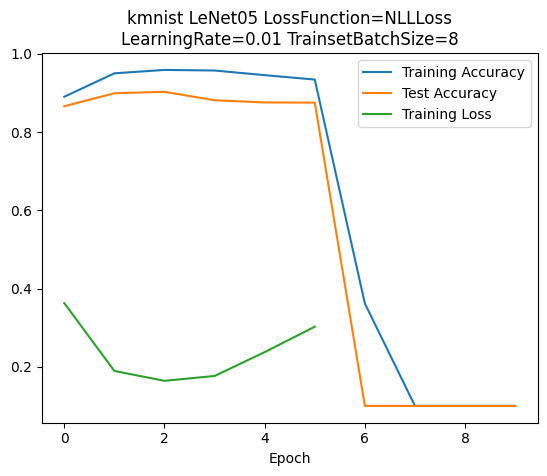

    Actual Labels  Predicted Labels
0               2                 0
1               9                 0
2               3                 0
3               8                 0
4               3                 0
..            ...               ...
95              3                 0
96              6                 0
97              5                 0
98              9                 0
99              2                 0

[100 rows x 2 columns]


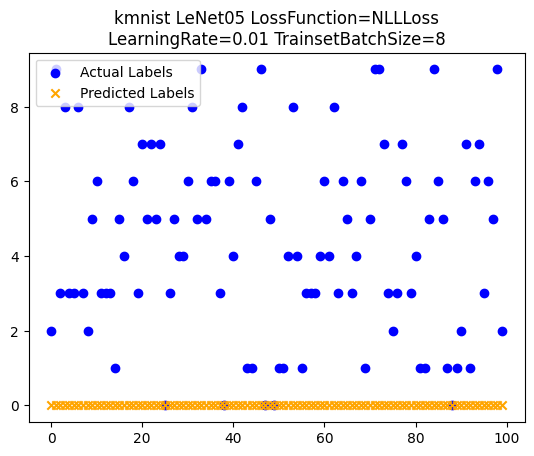

In [ ]:
name='LeNet05'
data = 'kmnist'
lr = 0.01
batchsize = 8
loss='nll'
epochs = 10
km_lenet05_max=RunModel(name,data,lr,batchsize,loss,epochs)

#### 3.3.6 LeNet06 - Setting 6 for KMNIST Dataset

Epoch: 1 	Training Loss: 0.349227 	Training Accuracy: 89.30% 	Test Accuracy: 87.06%
Epoch: 2 	Training Loss: 0.172265 	Training Accuracy: 95.36% 	Test Accuracy: 88.52%
Epoch: 3 	Training Loss: 0.168079 	Training Accuracy: 95.62% 	Test Accuracy: 90.10%
Epoch: 4 	Training Loss: 0.148172 	Training Accuracy: 96.21% 	Test Accuracy: 90.58%
Epoch: 5 	Training Loss: 0.146526 	Training Accuracy: 96.46% 	Test Accuracy: 88.80%
Epoch: 6 	Training Loss: 0.184380 	Training Accuracy: 95.77% 	Test Accuracy: 84.15%
Epoch: 7 	Training Loss: 0.212946 	Training Accuracy: 95.30% 	Test Accuracy: 86.52%
Epoch: 8 	Training Loss: 1.998489 	Training Accuracy: 23.19% 	Test Accuracy: 10.00%
Epoch: 9 	Training Loss: 2.305349 	Training Accuracy: 10.08% 	Test Accuracy: 10.00%
Epoch: 10 	Training Loss: 2.305407 	Training Accuracy: 10.04% 	Test Accuracy: 10.00%


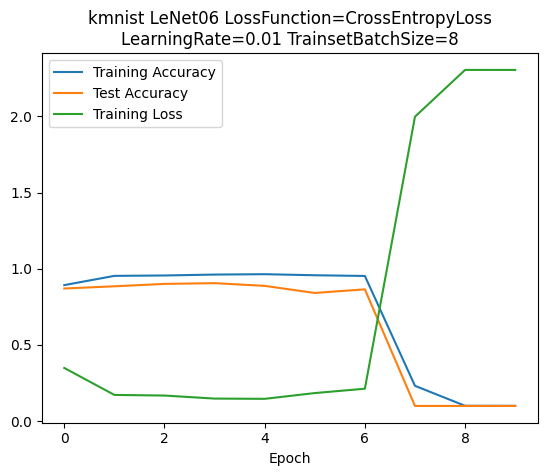

    Actual Labels  Predicted Labels
0               2                 3
1               9                 3
2               3                 3
3               8                 3
4               3                 3
..            ...               ...
95              3                 3
96              6                 3
97              5                 3
98              9                 3
99              2                 3

[100 rows x 2 columns]


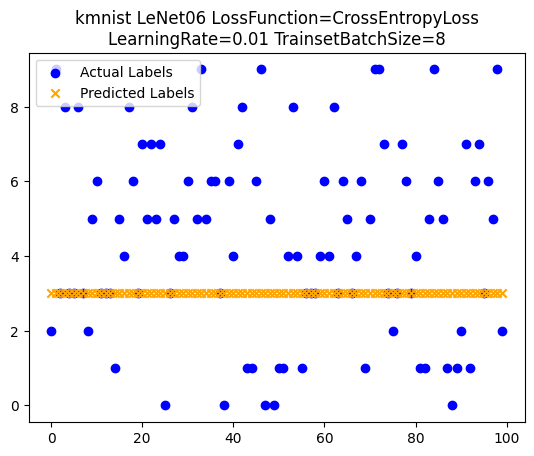

In [ ]:
name='LeNet06'
data = 'kmnist'
lr = 0.01
batchsize = 8
loss='ce'
epochs = 10
km_lenet06_max=RunModel(name,data,lr,batchsize,loss,epochs)

#### 3.3.7 Performance Comparison Across All LeNet Models for KMNIST Dataset

In [ ]:
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Collect the best test accuracy from all Lenet models
frames = [km_lenet01_max, km_lenet02_max, km_lenet03_max, km_lenet04_max, km_lenet05_max, km_lenet06_max]
km_lenet_all = pd.concat(frames, ignore_index=True)
km_lenet_all.to_csv("/content/drive/MyDrive/gp_525/km_lenet_all.csv")
km_lenet_all

km_lenet_all = pd.read_csv('/content/drive/MyDrive/gp_525/km_lenet_all.csv')
km_lenet_all


,Model,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
0,LeNet01,30,0.0001,1.0000,0.9506
1,LeNet02,20,0.0001,1.0000,0.9563
2,LeNet03,30,0.0209,0.9944,0.9430
3,LeNet04,30,0.0218,0.9935,0.9350
4,LeNet05,3,0.1641,0.9586,0.9027
5,LeNet06,4,0.1482,0.9621,0.9058


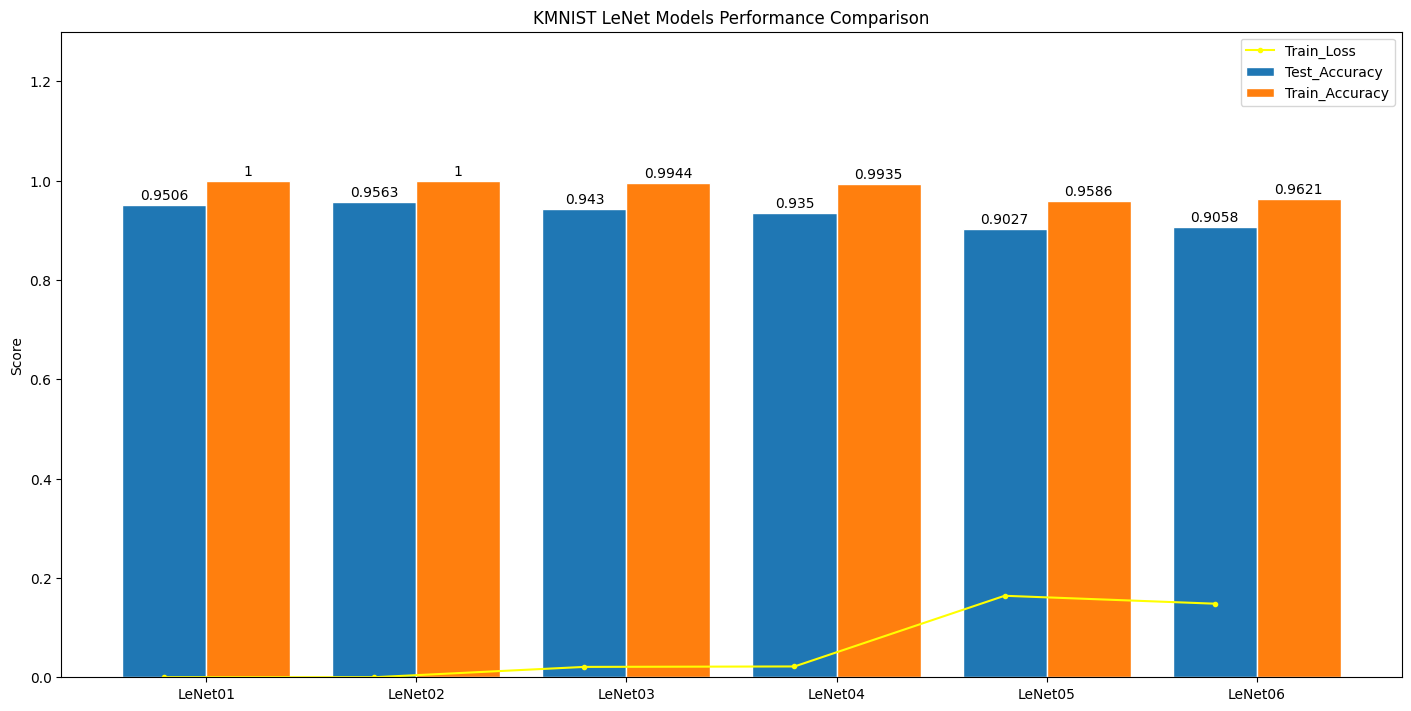

In [ ]:
# plt.style.use('ggplot')
plt.style.use('default')
modelName = km_lenet_all.Model
metric_score = {
    'Test_Accuracy': km_lenet_all.Test_Accuracy,
    'Train_Accuracy': km_lenet_all.Train_Accuracy
    
}

x = np.arange(len(modelName))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(14,7), layout='constrained')

for attribute, measurement in metric_score.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, edgecolor='white')
    ax.bar_label(rects, padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('KMNIST LeNet Models Performance Comparison')
ax.set_xticks(x + width/2, modelName)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0,1.3)

# plot train loss
plt.plot(km_lenet_all['Model'], km_lenet_all['Train_Loss'], color='yellow', marker='.', label='Train_Loss')
plt.legend()

plt.savefig('/content/drive/MyDrive/gp_525/km_lenet_all.png', dpi=300)
plt.show()

### 3.4 LeNet Model Training on K49 Dataset

Setting 1: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = NLLLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 64 </br>

Setting 2: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = CrossEntropyLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 64 </br>

Setting 3: </br>
  - Optimizer = SGD(Stochastic Gradient Descent) </br>
  - Loss function = CrossEntropyLoss </br>
  - Learing rate = 0.01 </br>
  - Train dataset batch size = 128 </br>

Similar to section 3.3. Each model parameter setting will be run in the function, and the following results will be obtained.
1. The training accuracy, loss, and test accuracy obtained by each epoch training.
2. Visualize the training accuracy, loss, and test accuracy changes with epochs.
3. The prediction of the model in the first 100 data of the test set and visualization.
4. The return from function is based on the best test accuracy.

Finally, 3.3.7 includes the summary and visualization of all 3 models.

#### 3.4.1 LeNet07 - Setting 1 for K49 Dataset

Epoch: 1 	Training Loss: 1.114902 	Training Accuracy: 70.61% 	Test Accuracy: 70.31%
Epoch: 2 	Training Loss: 0.741827 	Training Accuracy: 80.64% 	Test Accuracy: 70.98%
Epoch: 3 	Training Loss: 0.673729 	Training Accuracy: 82.58% 	Test Accuracy: 73.79%
Epoch: 4 	Training Loss: 0.623725 	Training Accuracy: 84.04% 	Test Accuracy: 75.21%
Epoch: 5 	Training Loss: 0.603785 	Training Accuracy: 84.63% 	Test Accuracy: 75.06%
Epoch: 6 	Training Loss: 0.585889 	Training Accuracy: 85.05% 	Test Accuracy: 76.21%
Epoch: 7 	Training Loss: 0.579184 	Training Accuracy: 85.43% 	Test Accuracy: 74.14%
Epoch: 8 	Training Loss: 0.561980 	Training Accuracy: 85.93% 	Test Accuracy: 76.08%
Epoch: 9 	Training Loss: 0.559040 	Training Accuracy: 85.97% 	Test Accuracy: 75.78%
Epoch: 10 	Training Loss: 0.553304 	Training Accuracy: 86.32% 	Test Accuracy: 78.36%
Epoch: 11 	Training Loss: 0.550465 	Training Accuracy: 86.34% 	Test Accuracy: 78.65%
Epoch: 12 	Training Loss: 0.542909 	Training Accuracy: 86.61% 	Test Accura

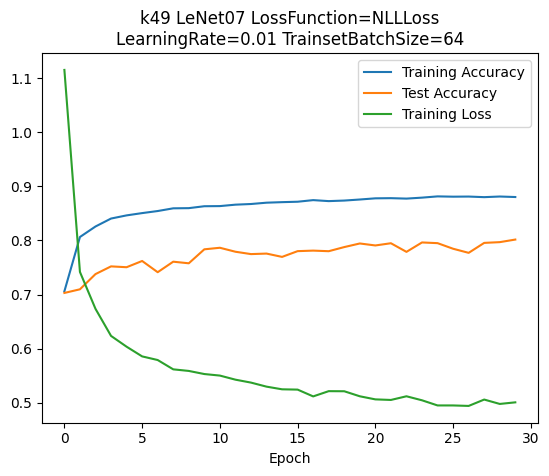

    Actual Labels  Predicted Labels
0              19                19
1              23                23
2              10                10
3              31                31
4              26                26
..            ...               ...
95              1                 1
96              6                 6
97             46                31
98             24                24
99             34                34

[100 rows x 2 columns]


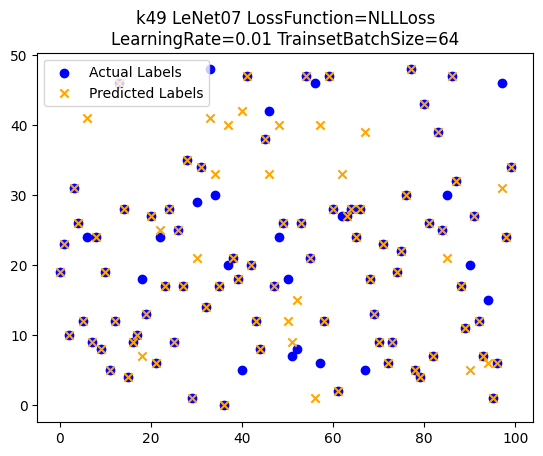

In [ ]:
name='LeNet07'
data = 'k49'
lr = 0.01
batchsize = 64
loss='nll'
epochs = 30
k49_lenet07_max=RunModel(name,data,lr,batchsize,loss,epochs)

In [ ]:
k49_lenet07_max

,Model,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
29,LeNet07,30,0.5010,0.8802,0.8016


#### 3.4.2 LeNet08 - Setting 2 for K49 Dataset

Epoch: 1 	Training Loss: 1.126720 	Training Accuracy: 69.92% 	Test Accuracy: 69.35%
Epoch: 2 	Training Loss: 0.734456 	Training Accuracy: 80.09% 	Test Accuracy: 71.12%
Epoch: 3 	Training Loss: 0.665972 	Training Accuracy: 82.04% 	Test Accuracy: 73.39%
Epoch: 4 	Training Loss: 0.614985 	Training Accuracy: 83.40% 	Test Accuracy: 75.58%
Epoch: 5 	Training Loss: 0.577886 	Training Accuracy: 84.43% 	Test Accuracy: 76.40%
Epoch: 6 	Training Loss: 0.560520 	Training Accuracy: 84.90% 	Test Accuracy: 76.67%
Epoch: 7 	Training Loss: 0.546808 	Training Accuracy: 85.46% 	Test Accuracy: 76.74%
Epoch: 8 	Training Loss: 0.537744 	Training Accuracy: 85.65% 	Test Accuracy: 77.89%
Epoch: 9 	Training Loss: 0.529760 	Training Accuracy: 85.97% 	Test Accuracy: 77.03%
Epoch: 10 	Training Loss: 0.519485 	Training Accuracy: 86.20% 	Test Accuracy: 79.27%
Epoch: 11 	Training Loss: 0.510558 	Training Accuracy: 86.45% 	Test Accuracy: 76.97%
Epoch: 12 	Training Loss: 0.497907 	Training Accuracy: 86.85% 	Test Accura

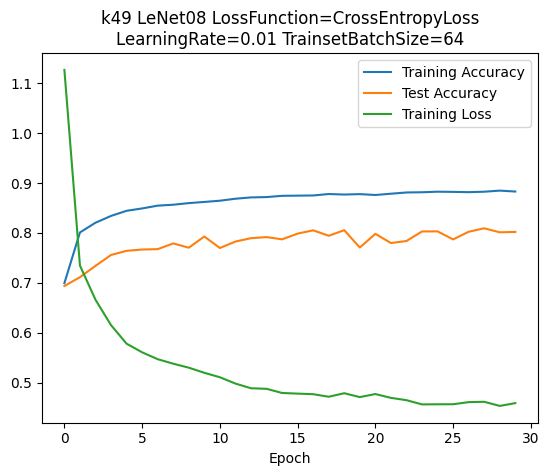

    Actual Labels  Predicted Labels
0              19                 6
1              23                23
2              10                 6
3              31                31
4              26                26
..            ...               ...
95              1                 1
96              6                 6
97             46                30
98             24                24
99             34                34

[100 rows x 2 columns]


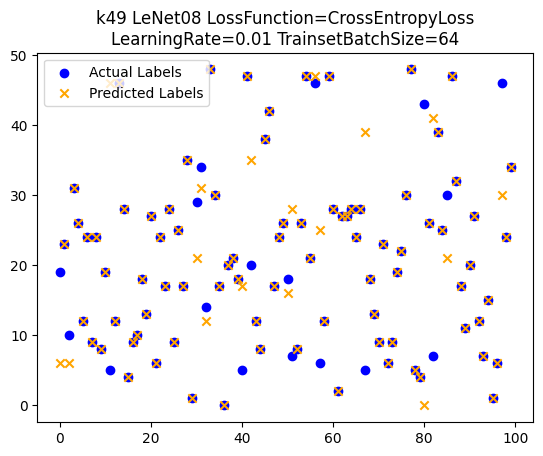

In [ ]:
name='LeNet08'
data = 'k49'
lr = 0.01
batchsize = 64
loss='ce'
epochs = 30
k49_lenet08_max=RunModel(name,data,lr,batchsize,loss,epochs)

#### 3.4.3 LeNet09 - Setting 3 for K49 Dataset

Epoch: 1 	Training Loss: 1.430342 	Training Accuracy: 61.32% 	Test Accuracy: 64.14%
Epoch: 2 	Training Loss: 0.738742 	Training Accuracy: 79.48% 	Test Accuracy: 71.60%
Epoch: 3 	Training Loss: 0.591205 	Training Accuracy: 83.54% 	Test Accuracy: 72.92%
Epoch: 4 	Training Loss: 0.521753 	Training Accuracy: 85.54% 	Test Accuracy: 77.64%
Epoch: 5 	Training Loss: 0.481118 	Training Accuracy: 86.59% 	Test Accuracy: 79.63%
Epoch: 6 	Training Loss: 0.456420 	Training Accuracy: 87.31% 	Test Accuracy: 79.23%
Epoch: 7 	Training Loss: 0.441635 	Training Accuracy: 87.78% 	Test Accuracy: 80.59%
Epoch: 8 	Training Loss: 0.429957 	Training Accuracy: 88.15% 	Test Accuracy: 80.08%
Epoch: 9 	Training Loss: 0.415230 	Training Accuracy: 88.54% 	Test Accuracy: 81.07%
Epoch: 10 	Training Loss: 0.415866 	Training Accuracy: 88.64% 	Test Accuracy: 81.02%
Epoch: 11 	Training Loss: 0.407608 	Training Accuracy: 88.80% 	Test Accuracy: 79.75%
Epoch: 12 	Training Loss: 0.400014 	Training Accuracy: 89.09% 	Test Accura

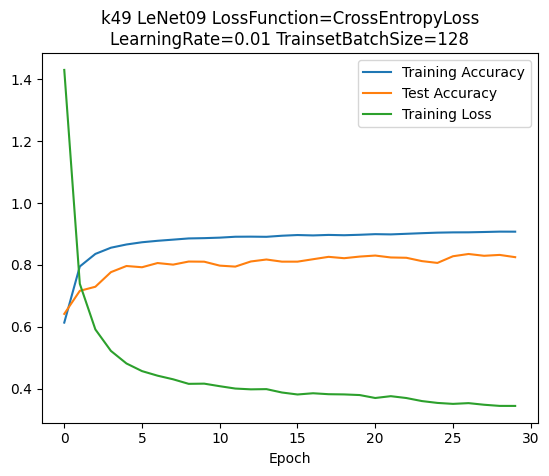

    Actual Labels  Predicted Labels
0              19                14
1              23                23
2              10                10
3              31                 3
4              26                26
..            ...               ...
95              1                 1
96              6                46
97             46                46
98             24                24
99             34                34

[100 rows x 2 columns]


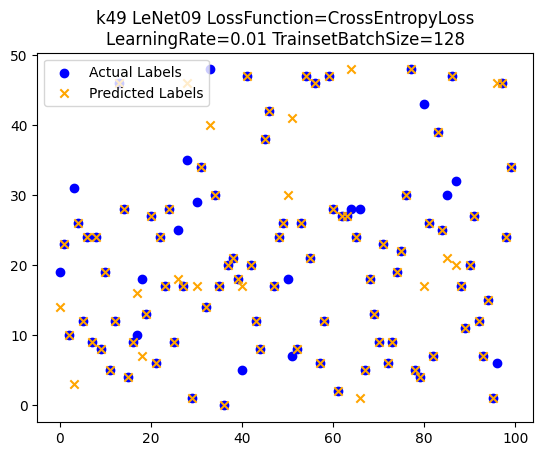

In [ ]:
name='LeNet09'
data = 'k49'
lr = 0.01
batchsize = 128
loss='ce'
epochs = 30
k49_lenet09_max=RunModel(name,data,lr,batchsize,loss,epochs)

#### 3.4.4 Performance Comparison Across All LeNet Models for K49 Dataset

In [ ]:
# Collect the best test accuracy from all Lenet models
frames = [k49_lenet07_max, k49_lenet08_max, k49_lenet09_max]
k49_lenet_all = pd.concat(frames, ignore_index=True)
k49_lenet_all.to_csv("/content/drive/MyDrive/gp_525/k49_lenet_all.csv")
k49_lenet_all

,Model,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
0,LeNet07,30,0.5010,0.8802,0.8016
1,LeNet08,28,0.4614,0.8825,0.8092
2,LeNet09,27,0.3529,0.9052,0.8351


In [ ]:
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
k49_lenet_all = pd.read_csv('/content/drive/MyDrive/gp_525/k49_lenet_all.csv')
k49_lenet_all

,Model,Epoch,Train_Loss,Train_Accuracy,Test_Accuracy
0,LeNet07,30,0.5010,0.8802,0.8016
1,LeNet08,28,0.4614,0.8825,0.8092
2,LeNet09,27,0.3529,0.9052,0.8351


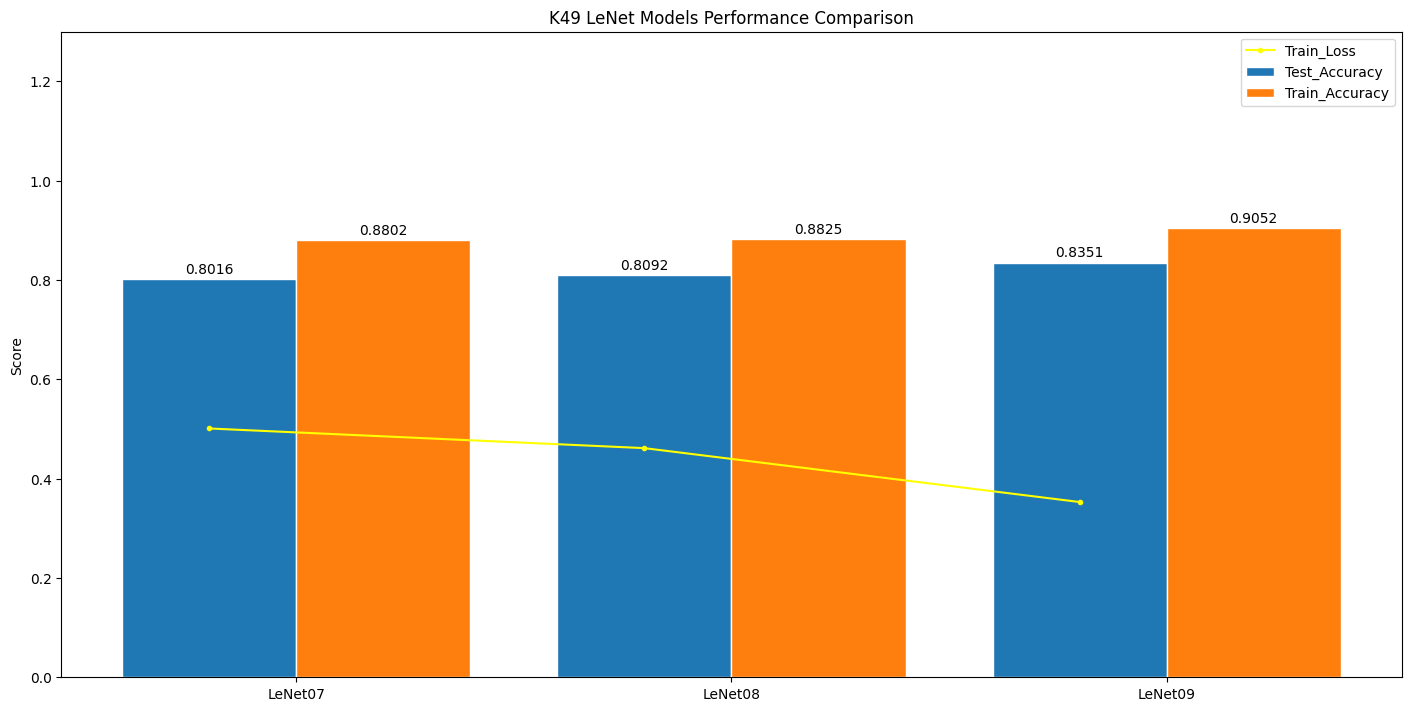

In [ ]:
# plt.style.use('ggplot')
plt.style.use('default')
modelName = k49_lenet_all.Model
metric_score = {
    'Test_Accuracy': k49_lenet_all.Test_Accuracy,
    'Train_Accuracy': k49_lenet_all.Train_Accuracy
    
}

x = np.arange(len(modelName))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(14,7), layout='constrained')

for attribute, measurement in metric_score.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, edgecolor='white')
    ax.bar_label(rects, padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('K49 LeNet Models Performance Comparison')
ax.set_xticks(x + width/2, modelName)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0,1.3)

# plot train loss
plt.plot(k49_lenet_all['Model'], k49_lenet_all['Train_Loss'], color='yellow', marker='.', label='Train_Loss')
plt.legend()

plt.savefig('/content/drive/MyDrive/gp_525/k49_lenet_all.png', dpi=300)
plt.show()